In [909]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [910]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import os
import json
import joblib
import pickle
from pathlib import Path
import lightgbm as lgb
from lightgbm import LGBMRegressor
from statsmodels.discrete.count_model import ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP


from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from scipy.stats import poisson



warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

# Constants

In [911]:
MODEL_DIR = "./models" # To save models
RESULT_DIR = "./results" # To save results
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

In [912]:
TRAIN_START = '2024-01-01'
TRAIN_END = '2025-08-31'
MIN_DATA_THRESHOLD = 30
LOW_ZERO_THRESHOLD = 0.2 # Low zero share
MEDIUM_ZERO_THRESHOLD = 0.4 # Medium zero share
FORECAST_START ='2025-09-01'
FORECAST_END = '2025-09-30'

# We will use limited features for zero inflated models
ZERO_SHARE_FEATS = ['dayofweek', 'month', 'is_weekend','day','rolling_median_15','level_shift_30','level_shift_60']


# EDA

In [957]:
def load_data(df_path):
    df = pd.read_csv(df_path)
    print(f"Loaded {len(df)} records from {df_path}")

    # Convert DATE to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Get unique SKUs
    skus = df[['ITEM_CODE', 'NAME']].drop_duplicates()
    sku_list = list(zip(skus['ITEM_CODE'], skus['NAME']))

    print(f"Found {len(sku_list)} unique SKUs")
    for item_code, name in sku_list:
        print(f"  {item_code} - {name}")

    return df

In [958]:
df = load_data('/content/drive/MyDrive/Ordergrid_Task/mock_test (2).csv')

Loaded 5496 records from /content/drive/MyDrive/Ordergrid_Task/mock_test (2).csv
Found 10 unique SKUs
  111900-A - REAL_T
  111934-A - REAL_FLAME
  121234-A - HDR
  121914-A - THINK_PATIO
  121987-A - ENERGY_T
  177714-A - OUT_T
  261514-A - MICROWAVE
  561934-A - DISHWASHER
  661914-A - DRYER
  991234-A - REFRIGERATOR


### Daily Series Plots

Analysis

1. ENERGY_T and REFRIGERATOR :
    *   Both the time series are quite sparse (intermittent), with long periods of zero demand and then sudden spikes. This suggests that the product is either very low-demand or sold in infrequent batches, possibly to a specific type of customer or in response to a very specific event.
    *   Refrigerator also has a very short historical duration hence is new

2. REAL_T:
    *   More or less stationary with no clear upward or downward trend
    *   Spikes seem to be one or two months apart in 2024

3. REAL_FLAME:
    *   More or less stationary
    *   Peaks are one year apart in months 07-09

4. HDR

    *   Visual stationarity
    *   Similar ro REAL_FLAME

5. THINK_PATIO
    * Strong seasonality
    * Peaks at 07 and dips at 01

6. OUT_T

    * Intermittent demand with frequent spikes

7. MICROWAVE
    * Slight downward trend with weak seasonality
    * Some random spikes

8. DISHWASHER
    * Visual stationarity
    * Some spikes

9. DRYER
    * Similar to the previous two, this series appears to be stationary with a consistent baseline demand and a few large, non-seasonal spikes.

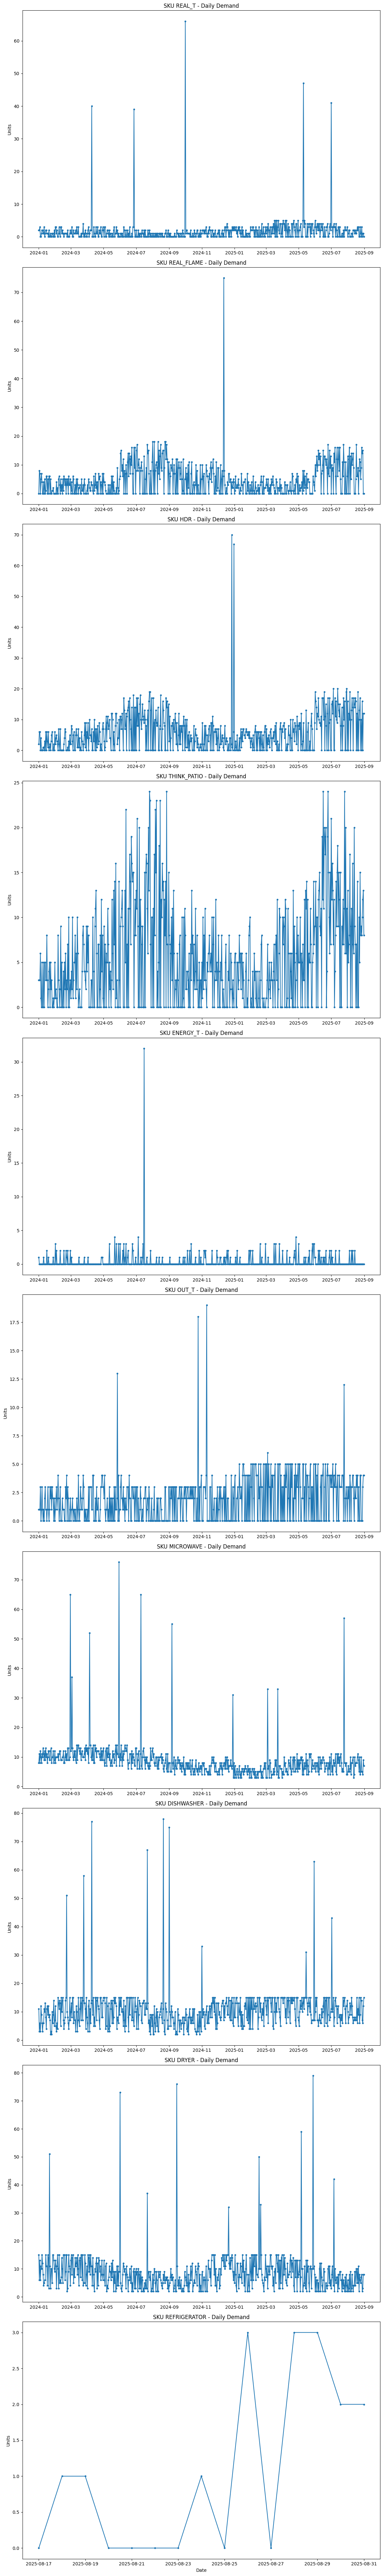

In [959]:
sample_skus = df["NAME"].unique()

fig, axes = plt.subplots(len(sample_skus), 1, figsize=(12, 8*len(sample_skus)))

for i, sku in enumerate(sample_skus):
    temp = df[df["NAME"] == sku]
    axes[i].plot(temp["DATE"], temp["VALUE"], marker=".", linestyle="-")
    axes[i].set_title(f"SKU {sku} - Daily Demand")
    axes[i].set_ylabel("Units")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

### Series Decomposition

DRYER
  * No trend
  * consistent high-frequency seasonal pattern.
  * seasonal effect is very small, as the y-axis ranges from approximately -0.75 to 0.75.
  * Most of the residuals are clustered around zero, which is a good sign, as it indicates that the trend and seasonal components explain a significant portion of the data's predictable variation. However, the plot clearly shows several large outliers corresponding to the spikes in the original series. The fact that these spikes appear in the residuals confirms they are unpredictable anomalies rather than a part of the series' inherent trend or seasonality.


DISHWASHER
  * Trend is more or less flat
  * High frequency, weekly or daily seasonality but weak magnitude
  * Clustered around 0 with some anomalies

MICROWAVE
  * Trend gradual weak downward trend
  * Same as above seasonality and residual

OUT_T
  * Same as above

ENERGY_T
  * Almost flat with one sharp increase
  * Same as before
  * The residuals are almost all zero, except for a single large outlier. This confirms that the unpredictable spike in the original data is an anomaly and is not part of any inherent trend or seasonal pattern.

THINK_PATIO
  * Fluctuating slightly upward trend
  *[link text](https://)

In [961]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_sku_timeseries(df, sku, model='additive', freq=7, plot=True, figsize=(20,16)):

    ts = df[df['NAME'] == sku].copy()
    ts = ts.sort_values('DATE')
    ts.set_index('DATE', inplace=True)

    # Check if we have enough points
    if len(ts) < freq*2:
        print(f"SKU {sku} has too few points ({len(ts)}) for decomposition.")
        return None

    decomposition = seasonal_decompose(ts['VALUE'], model=model, period=freq)

    if plot:
        fig = decomposition.plot()
        fig.set_size_inches(figsize)
        plt.suptitle(f"Time Series Decomposition for SKU {sku}", fontsize=16)
        plt.show()

    return decomposition

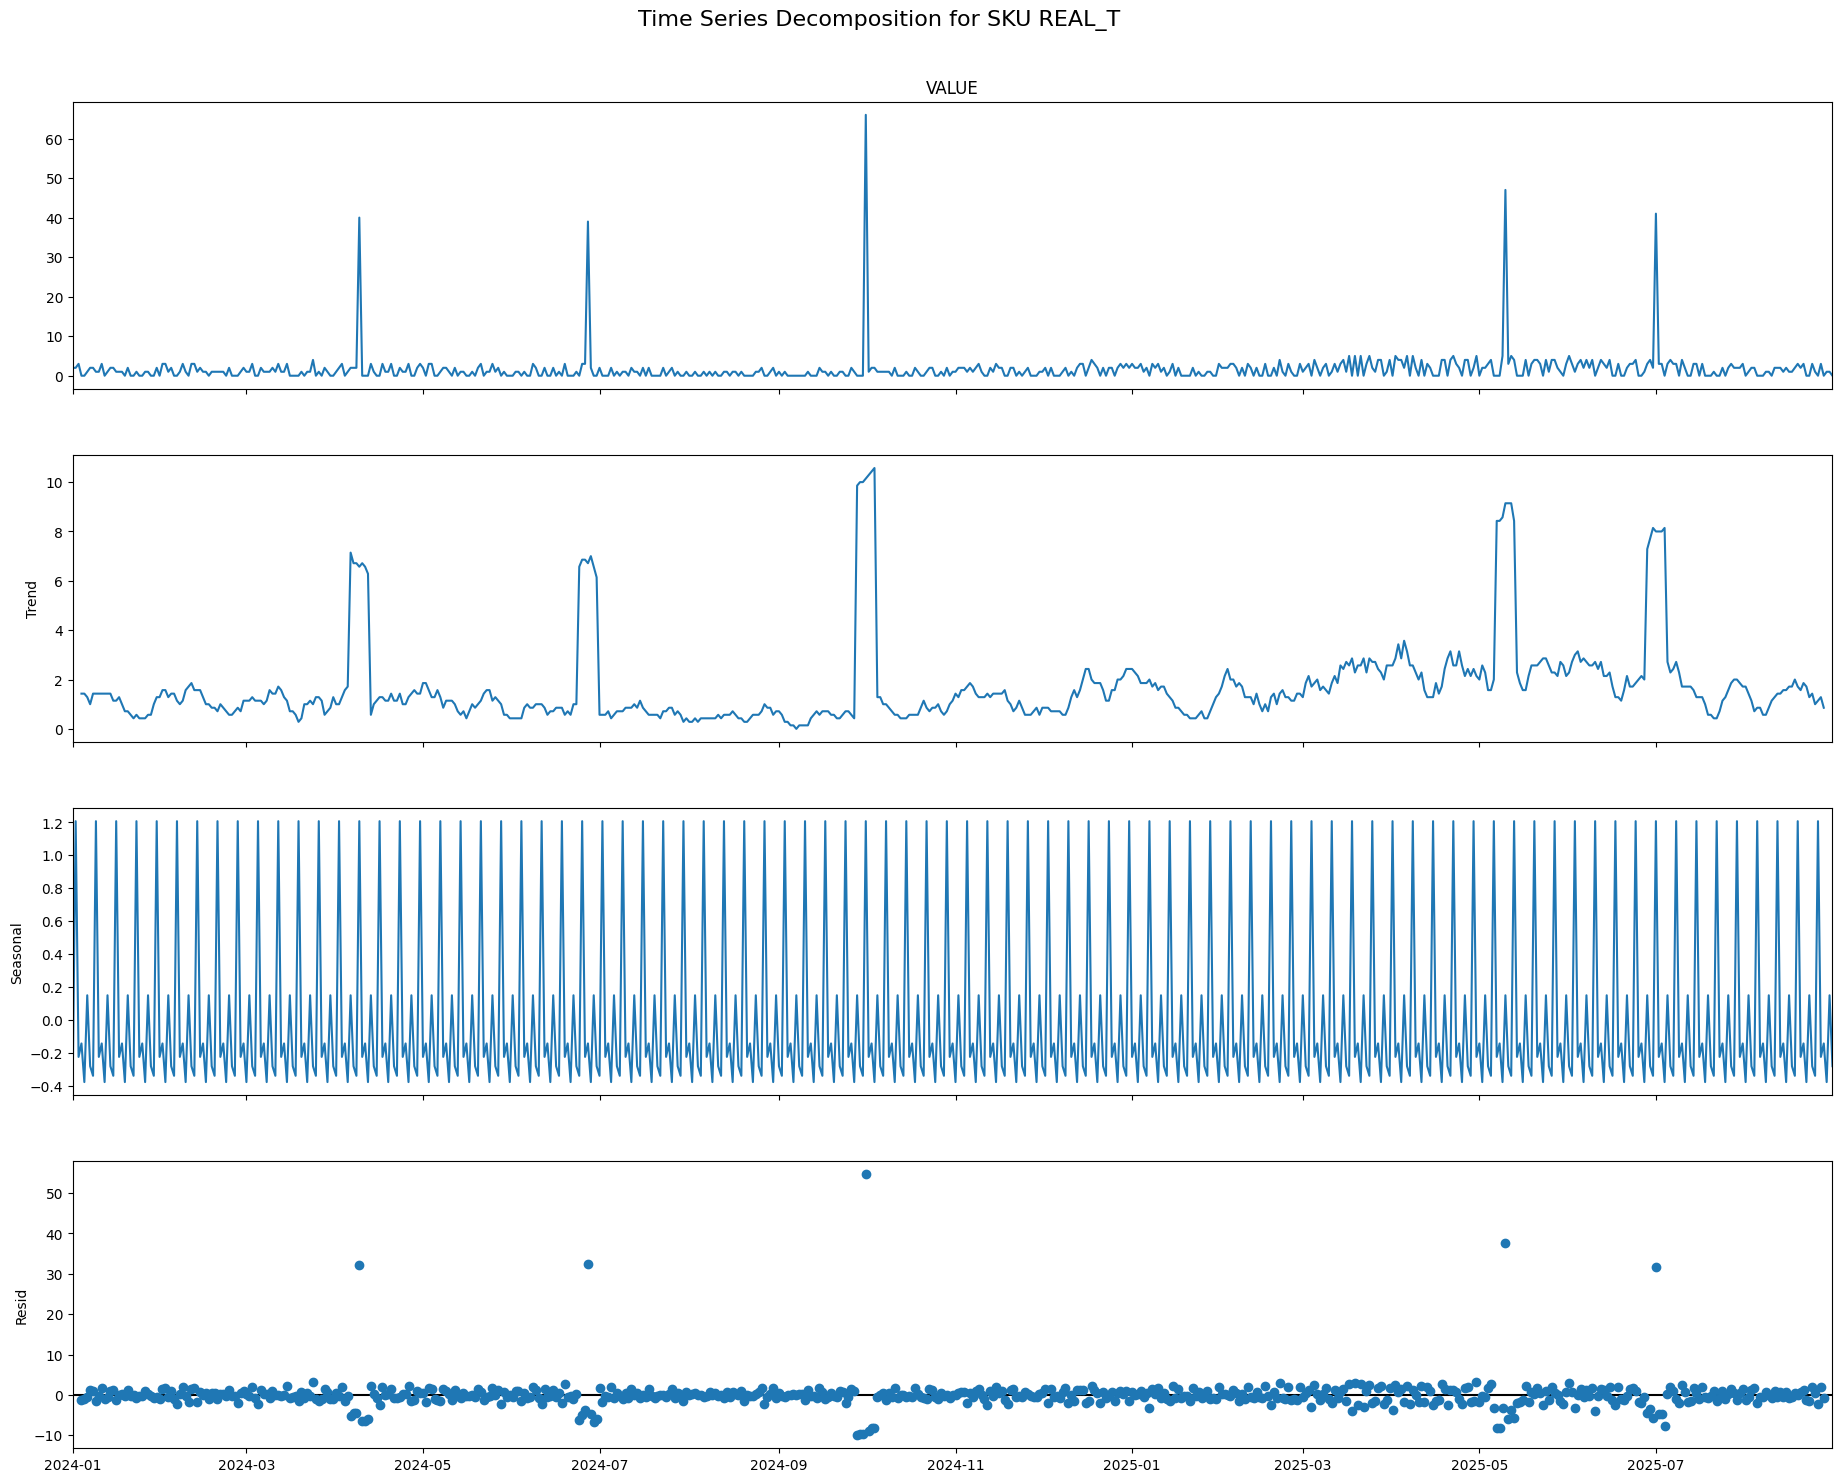

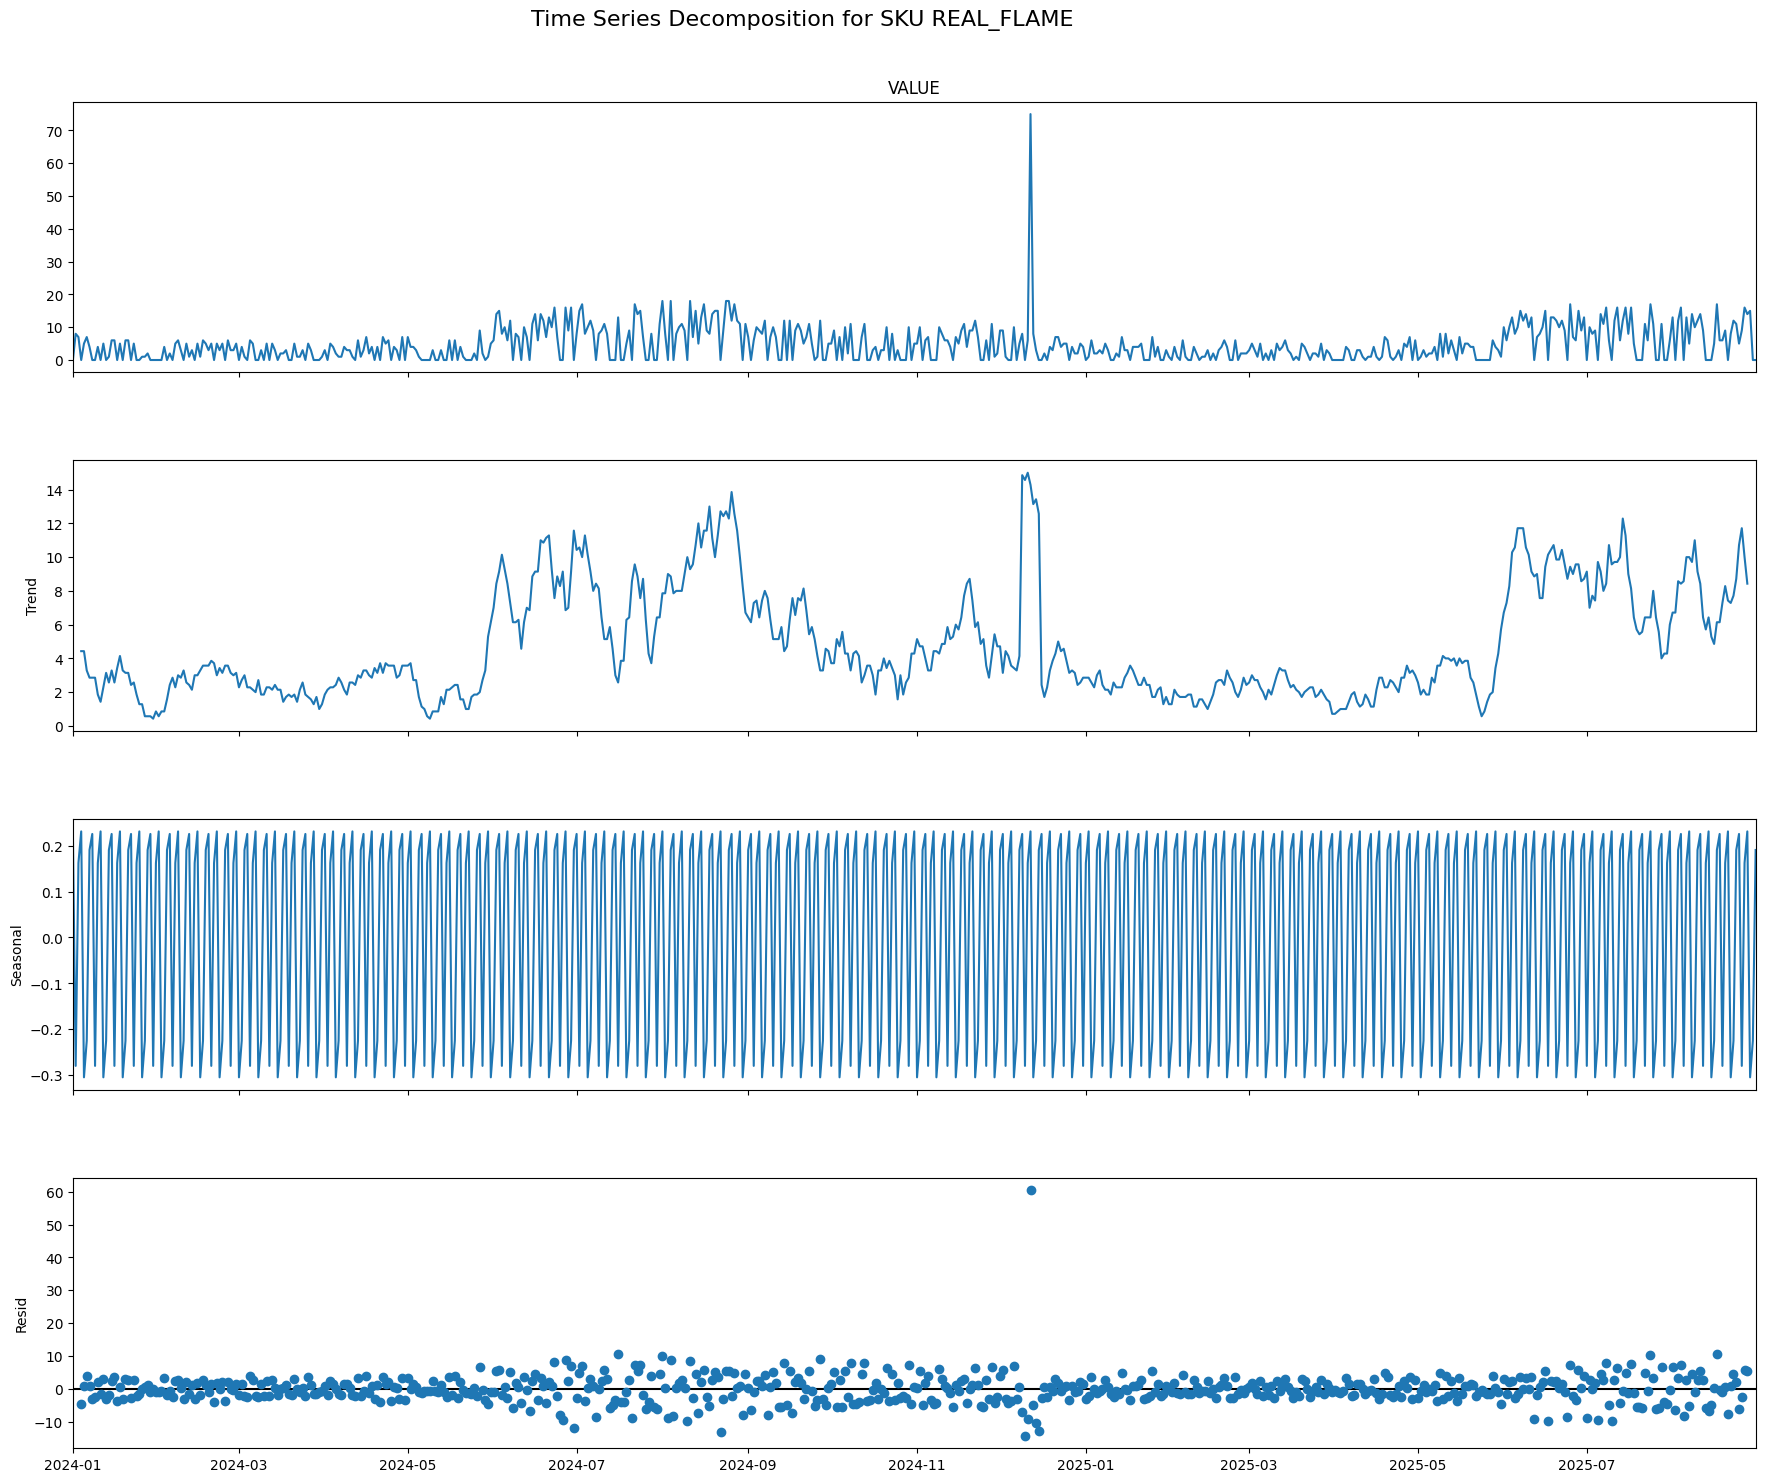

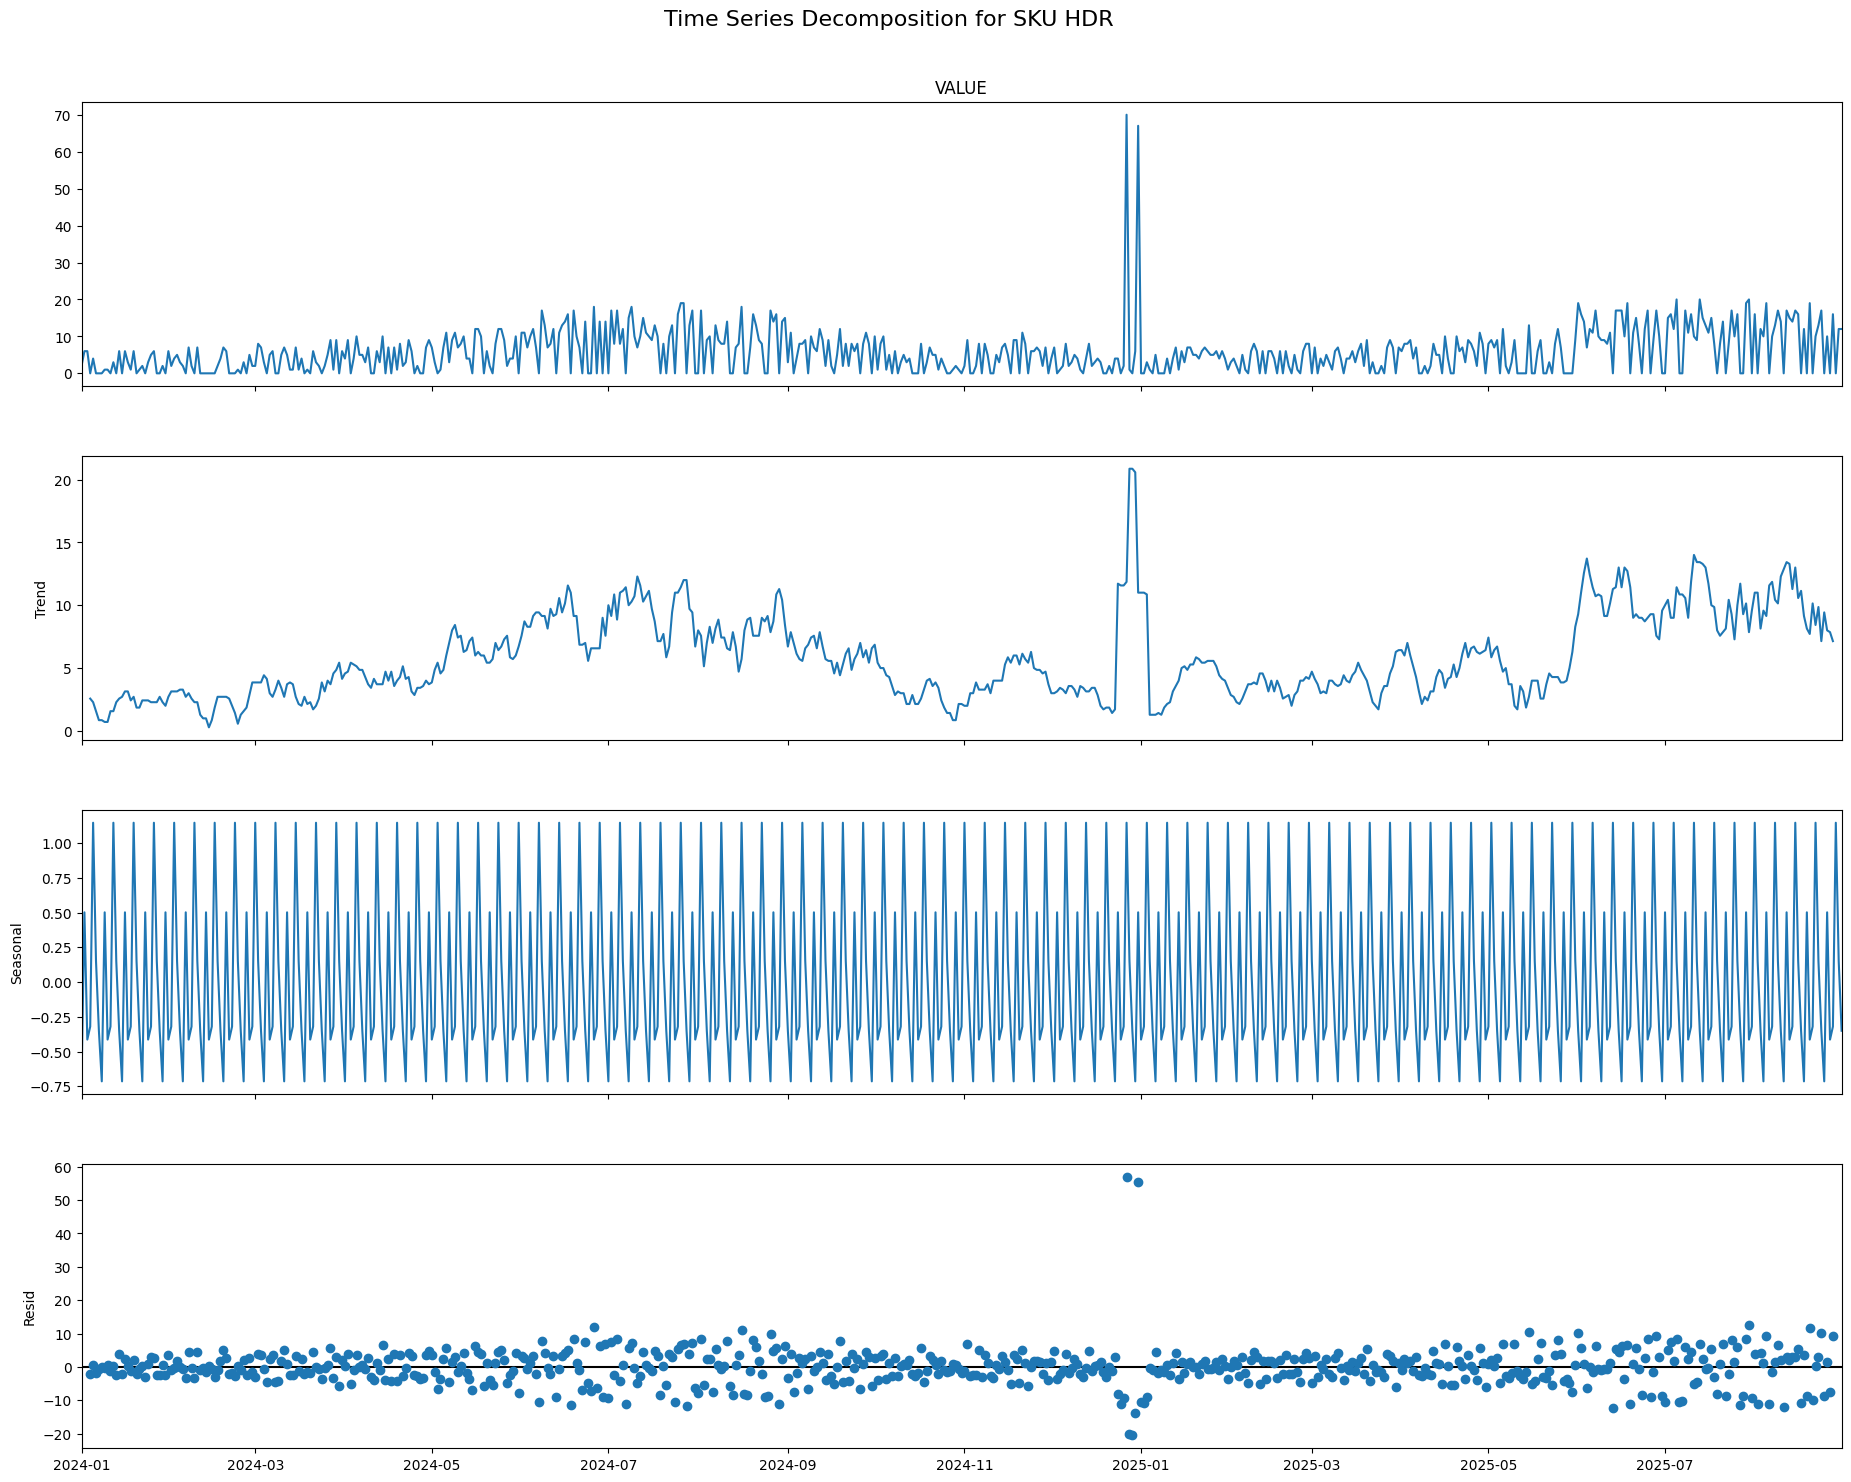

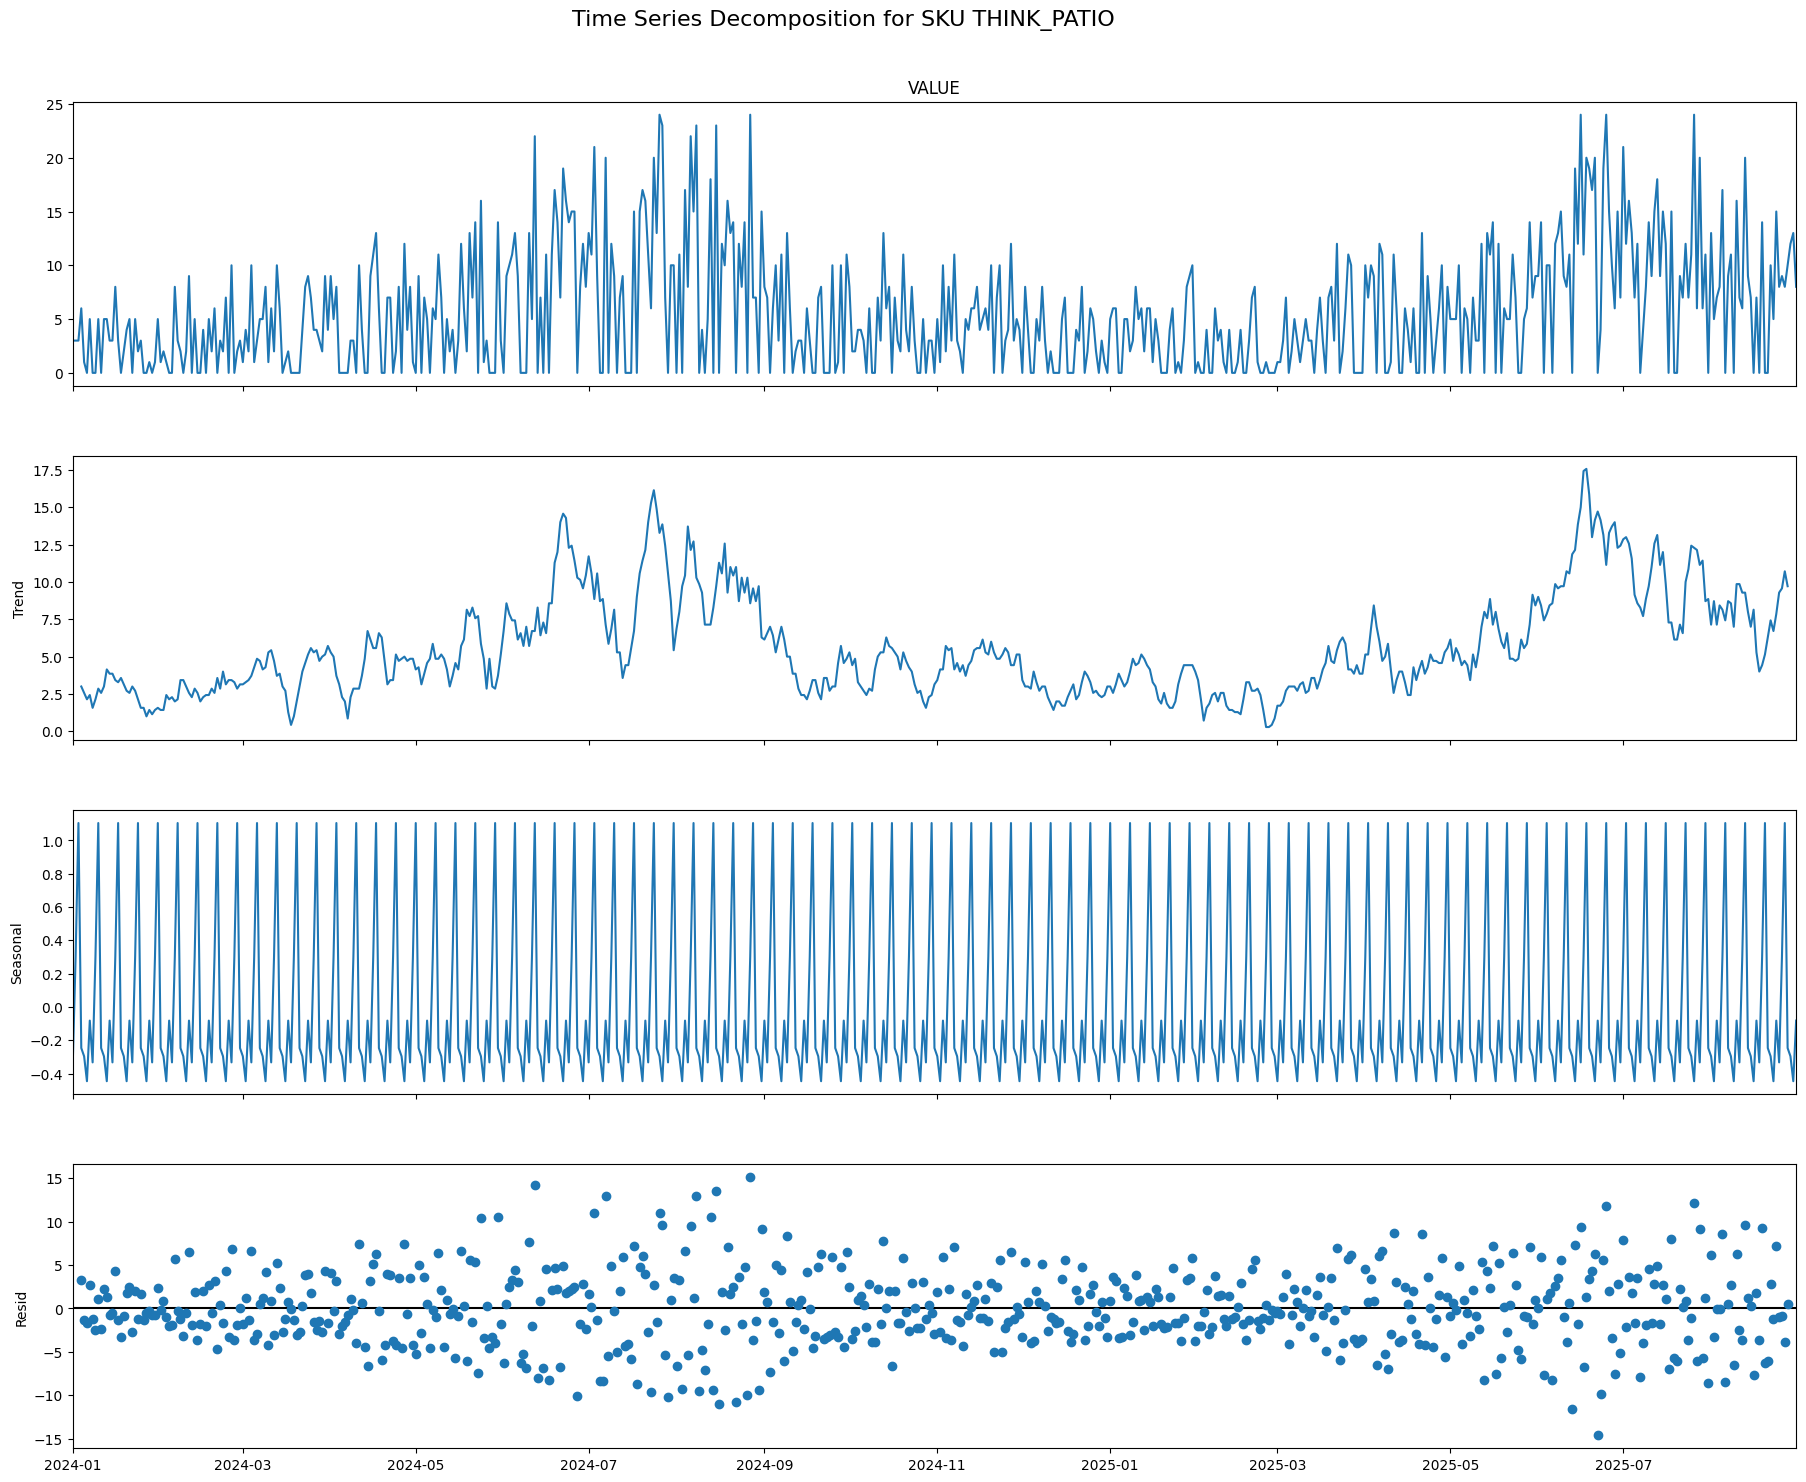

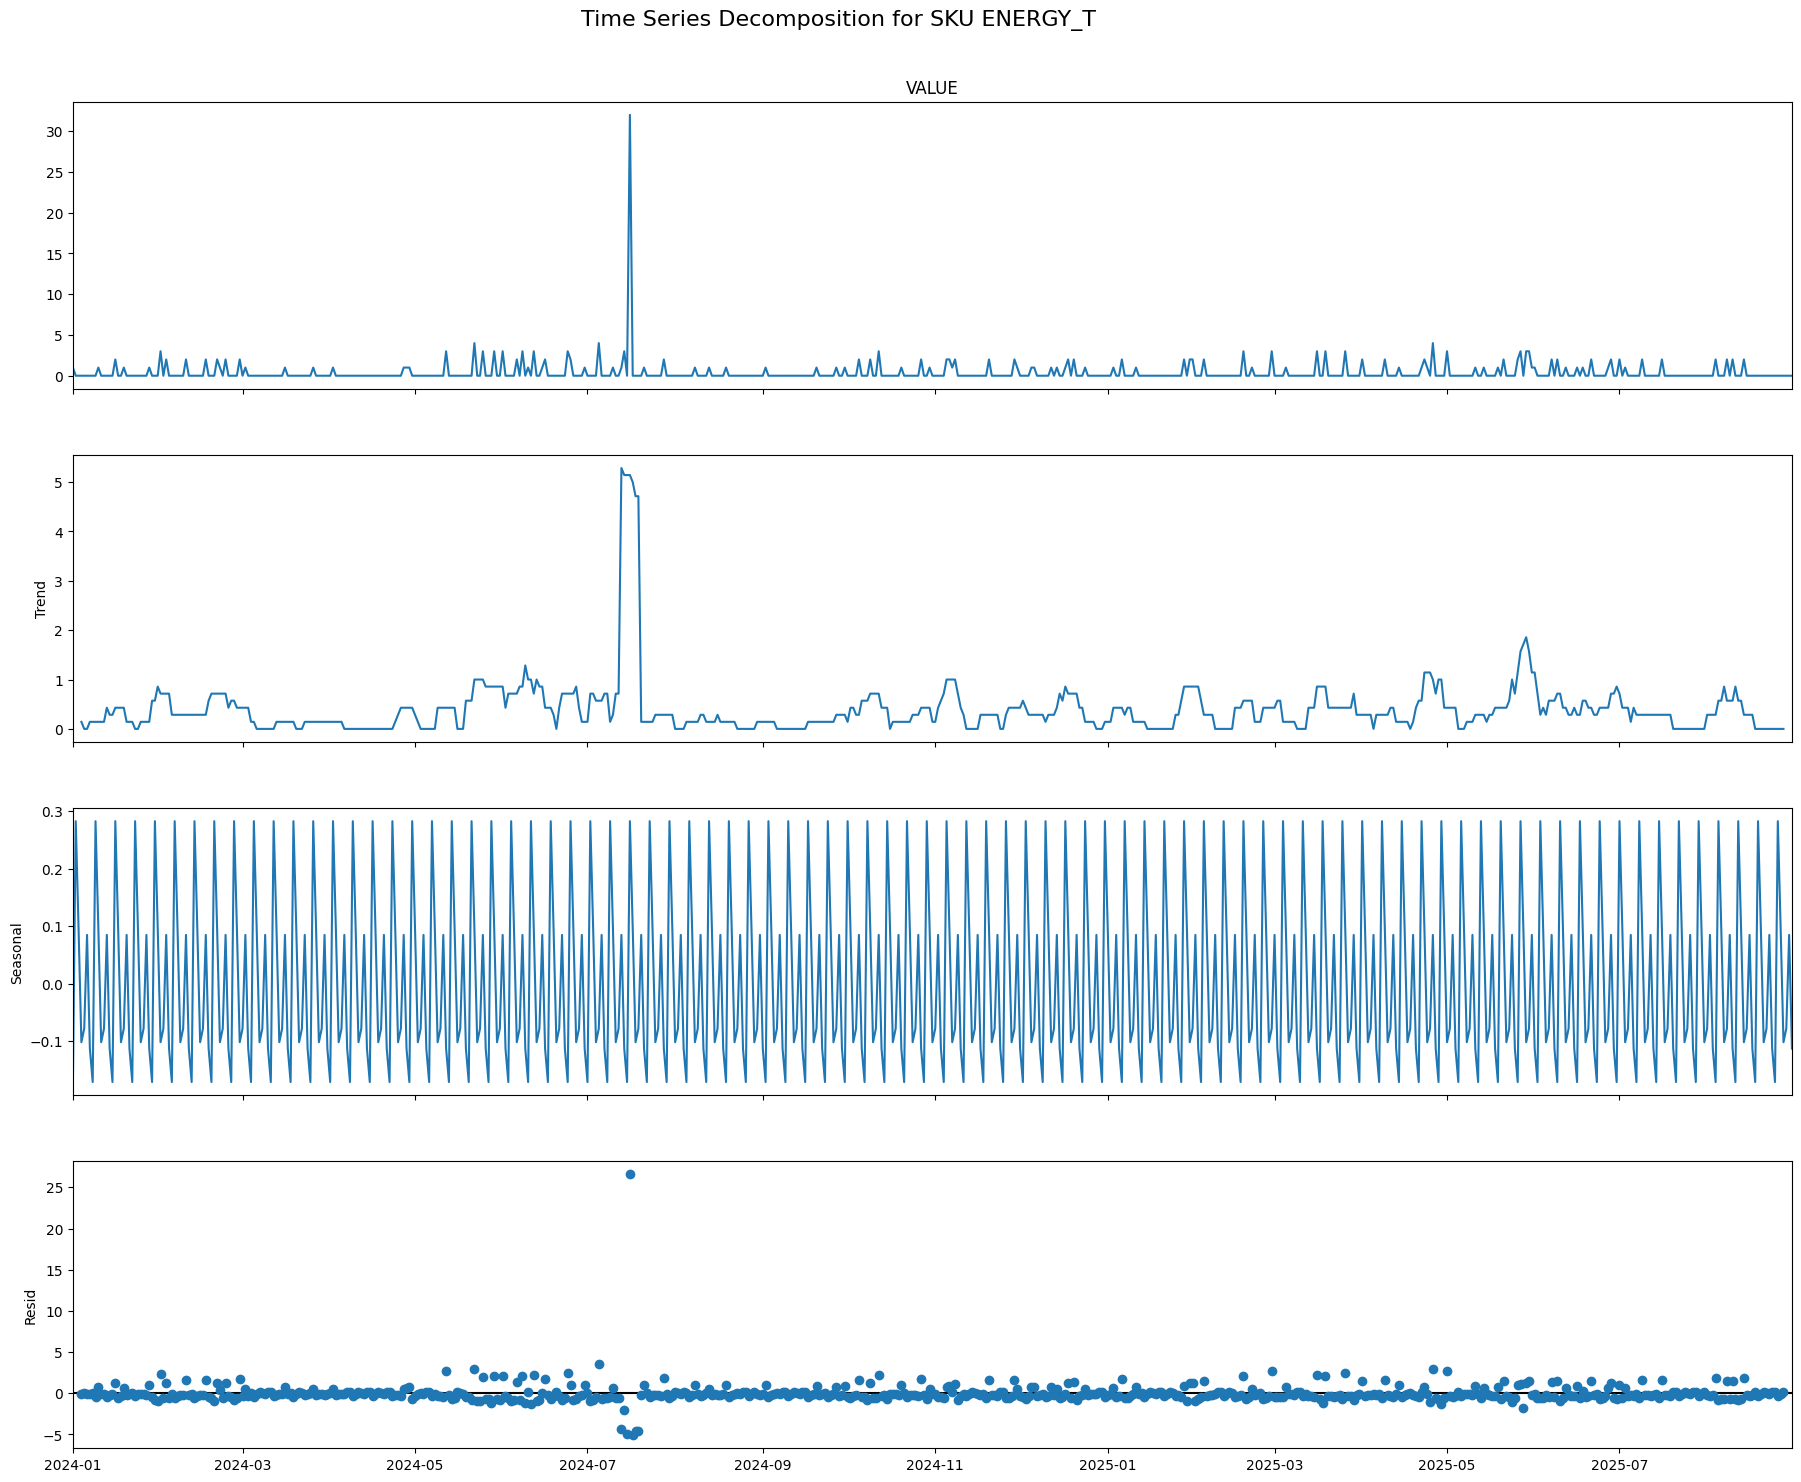

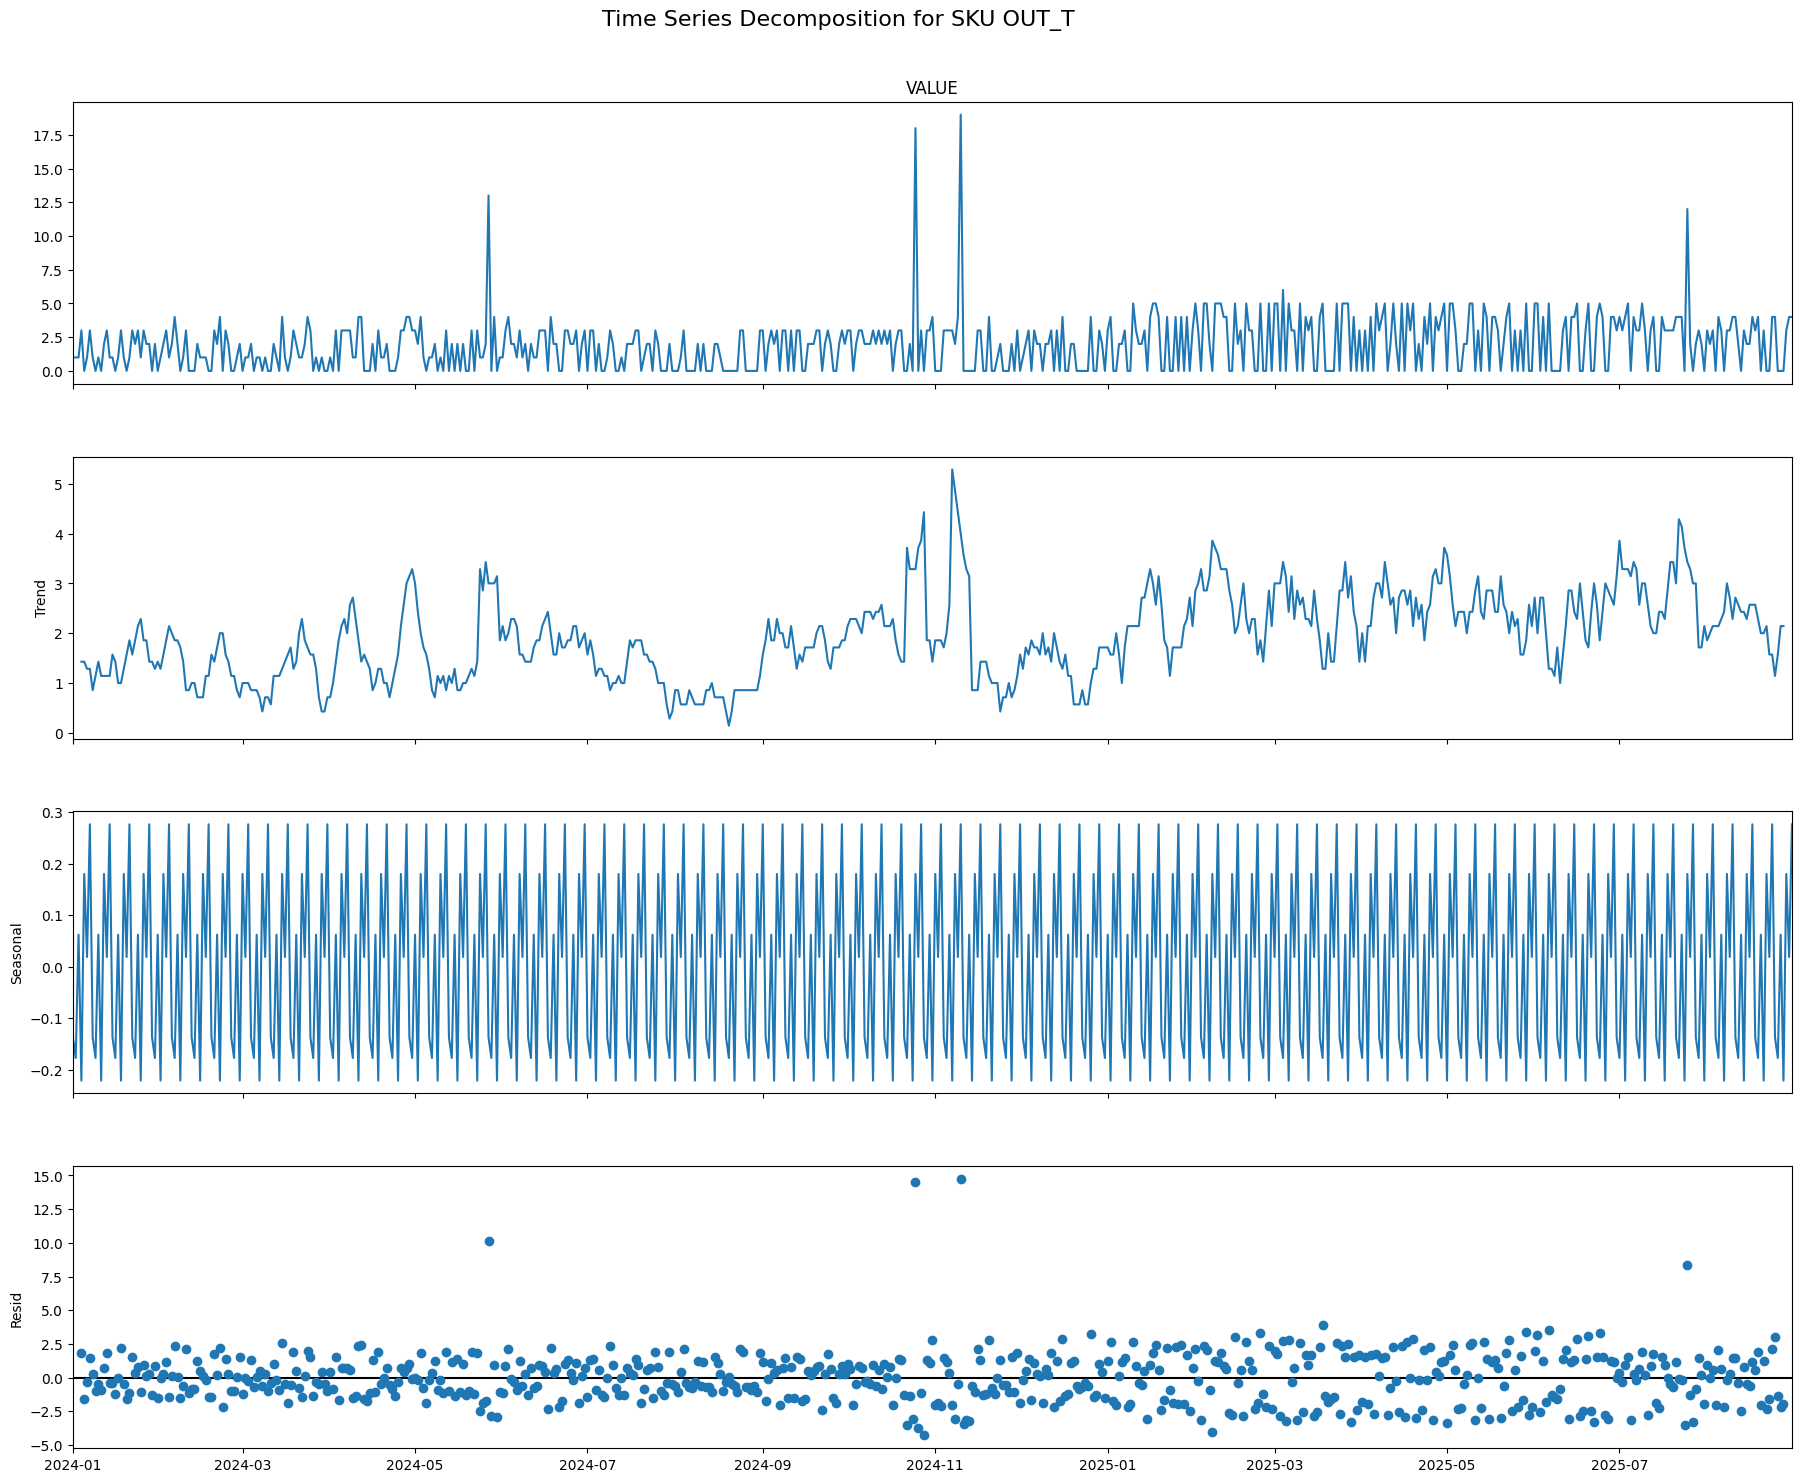

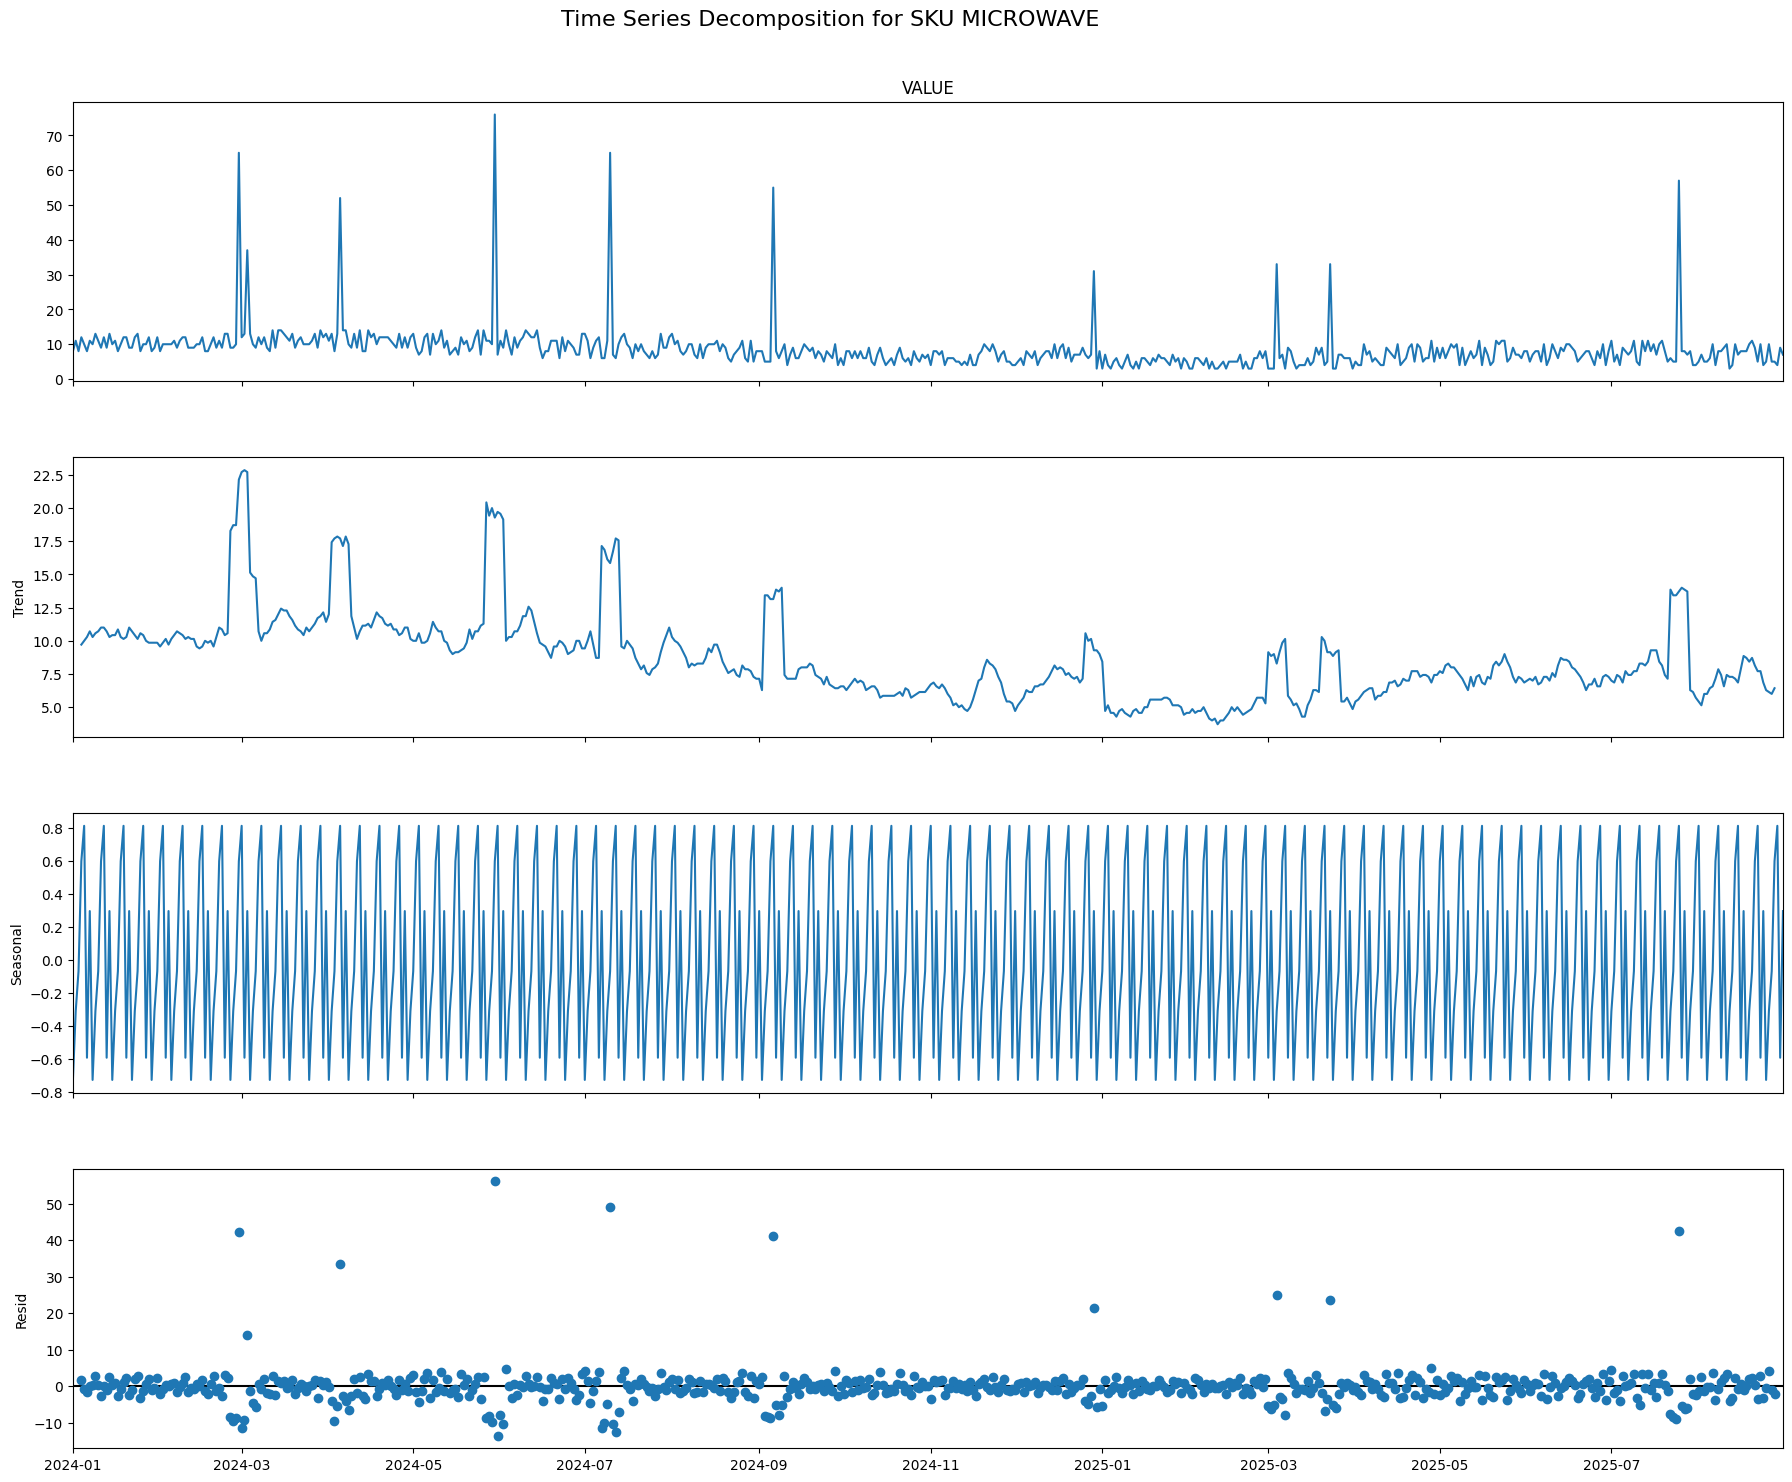

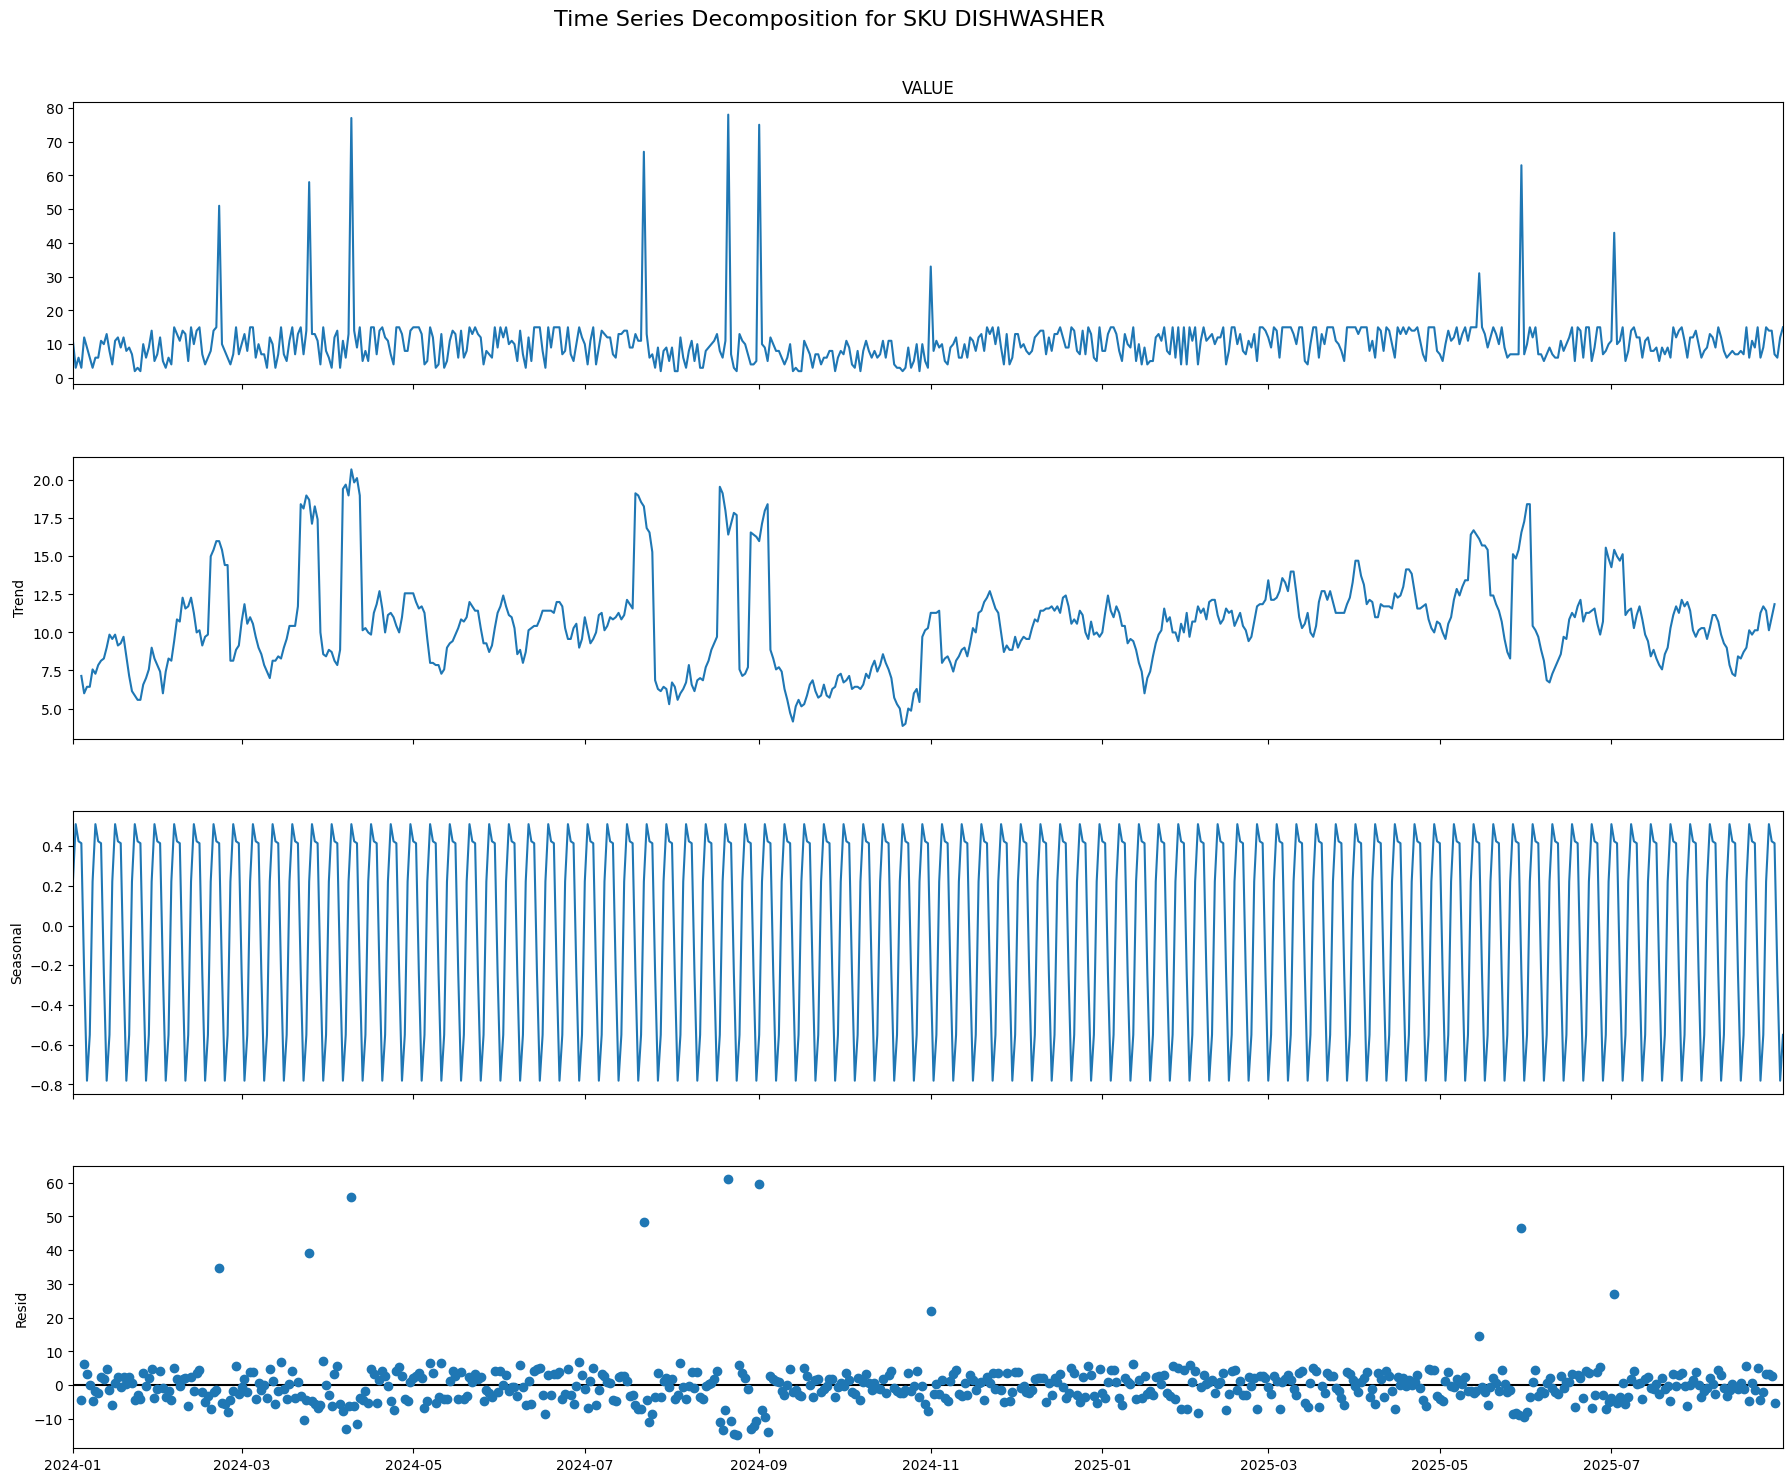

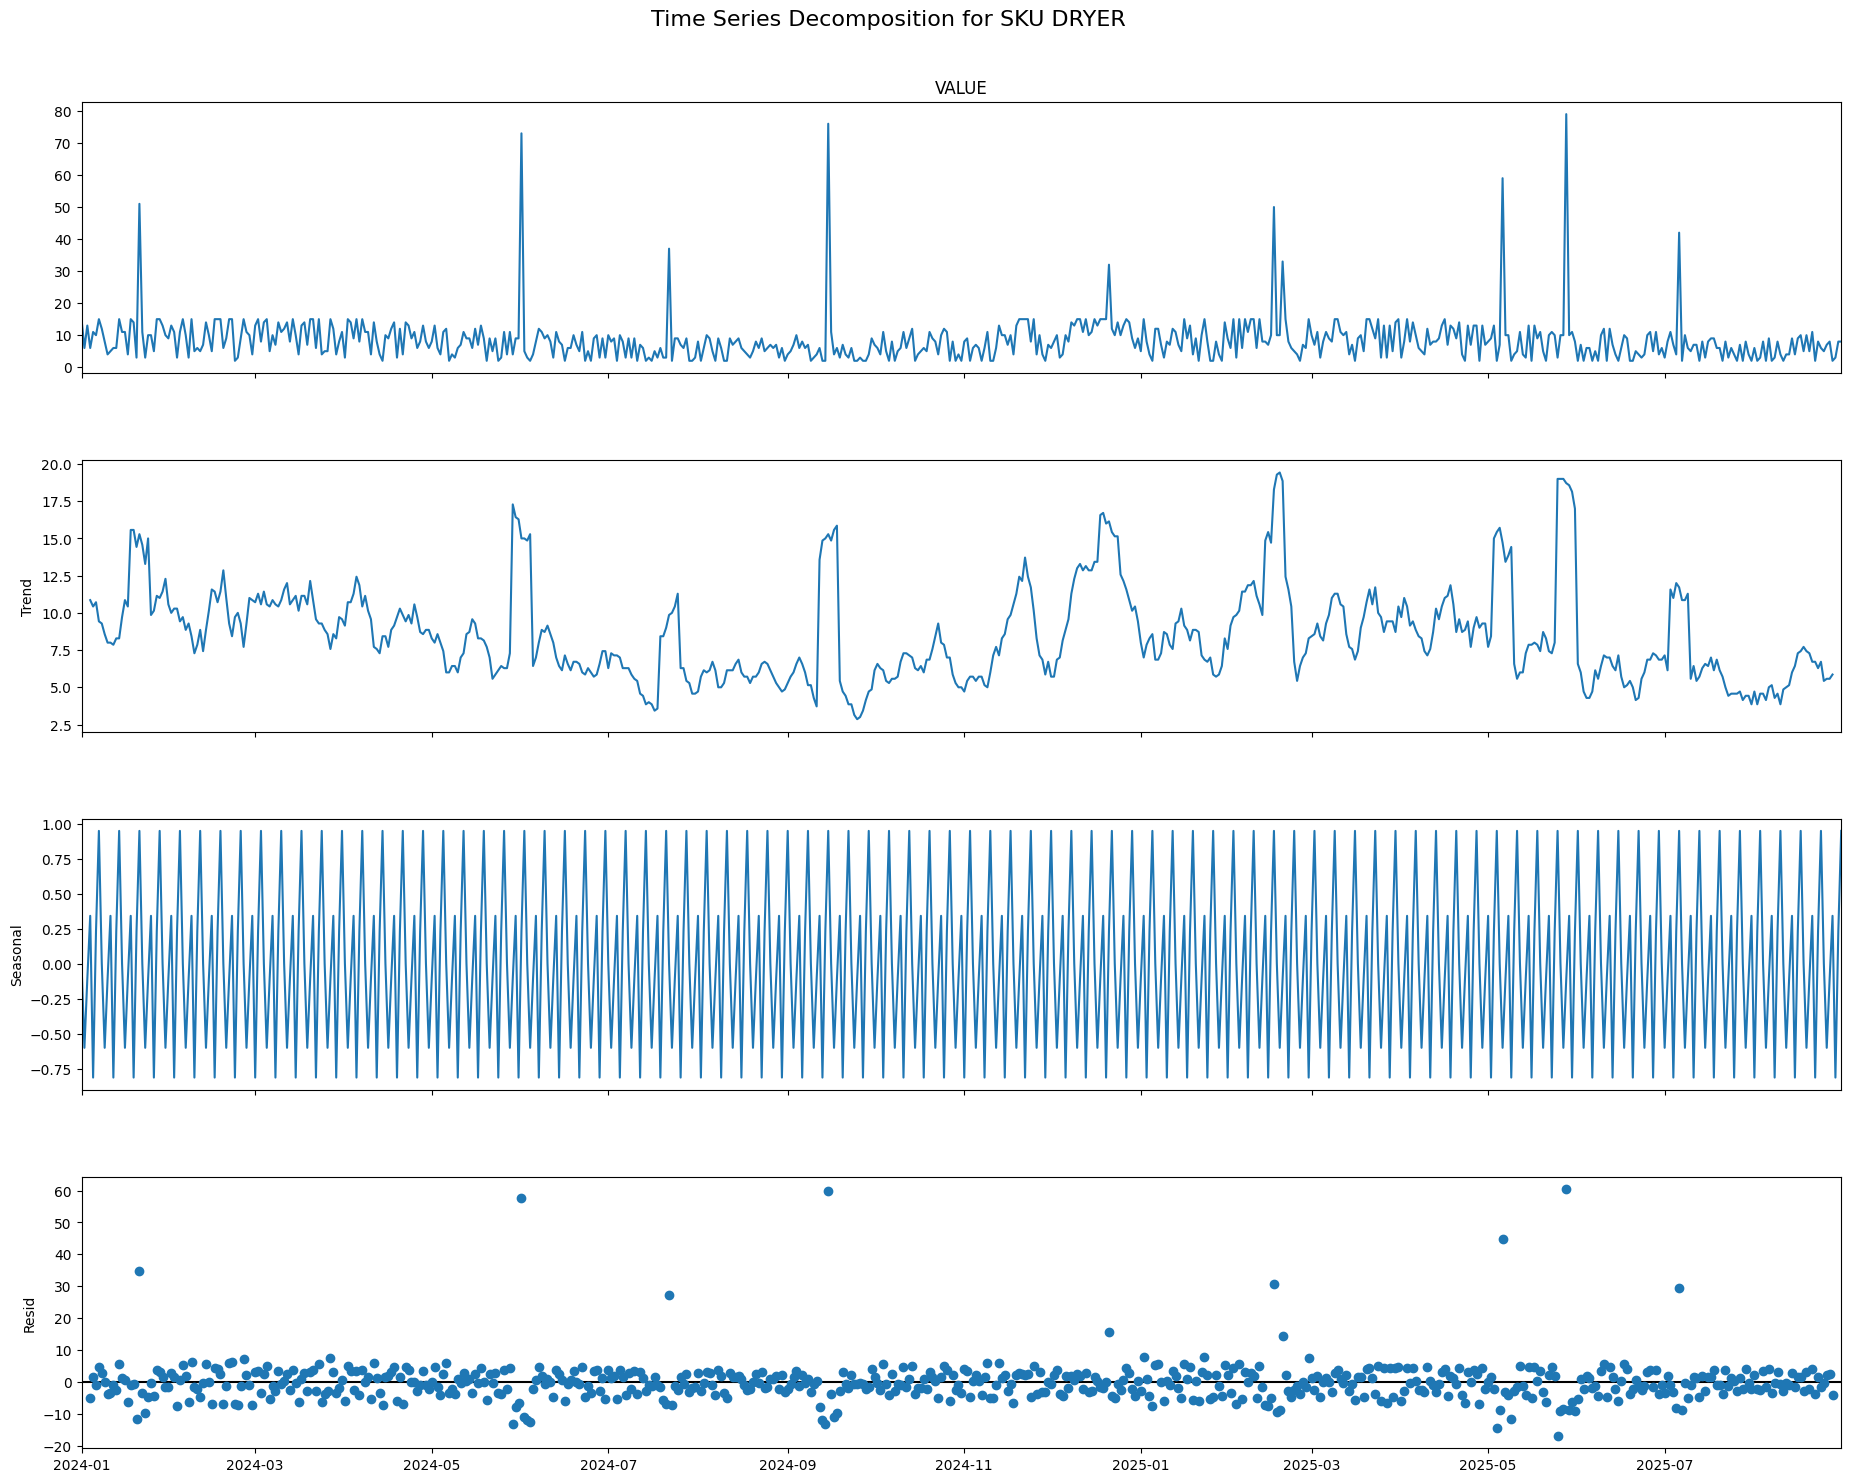

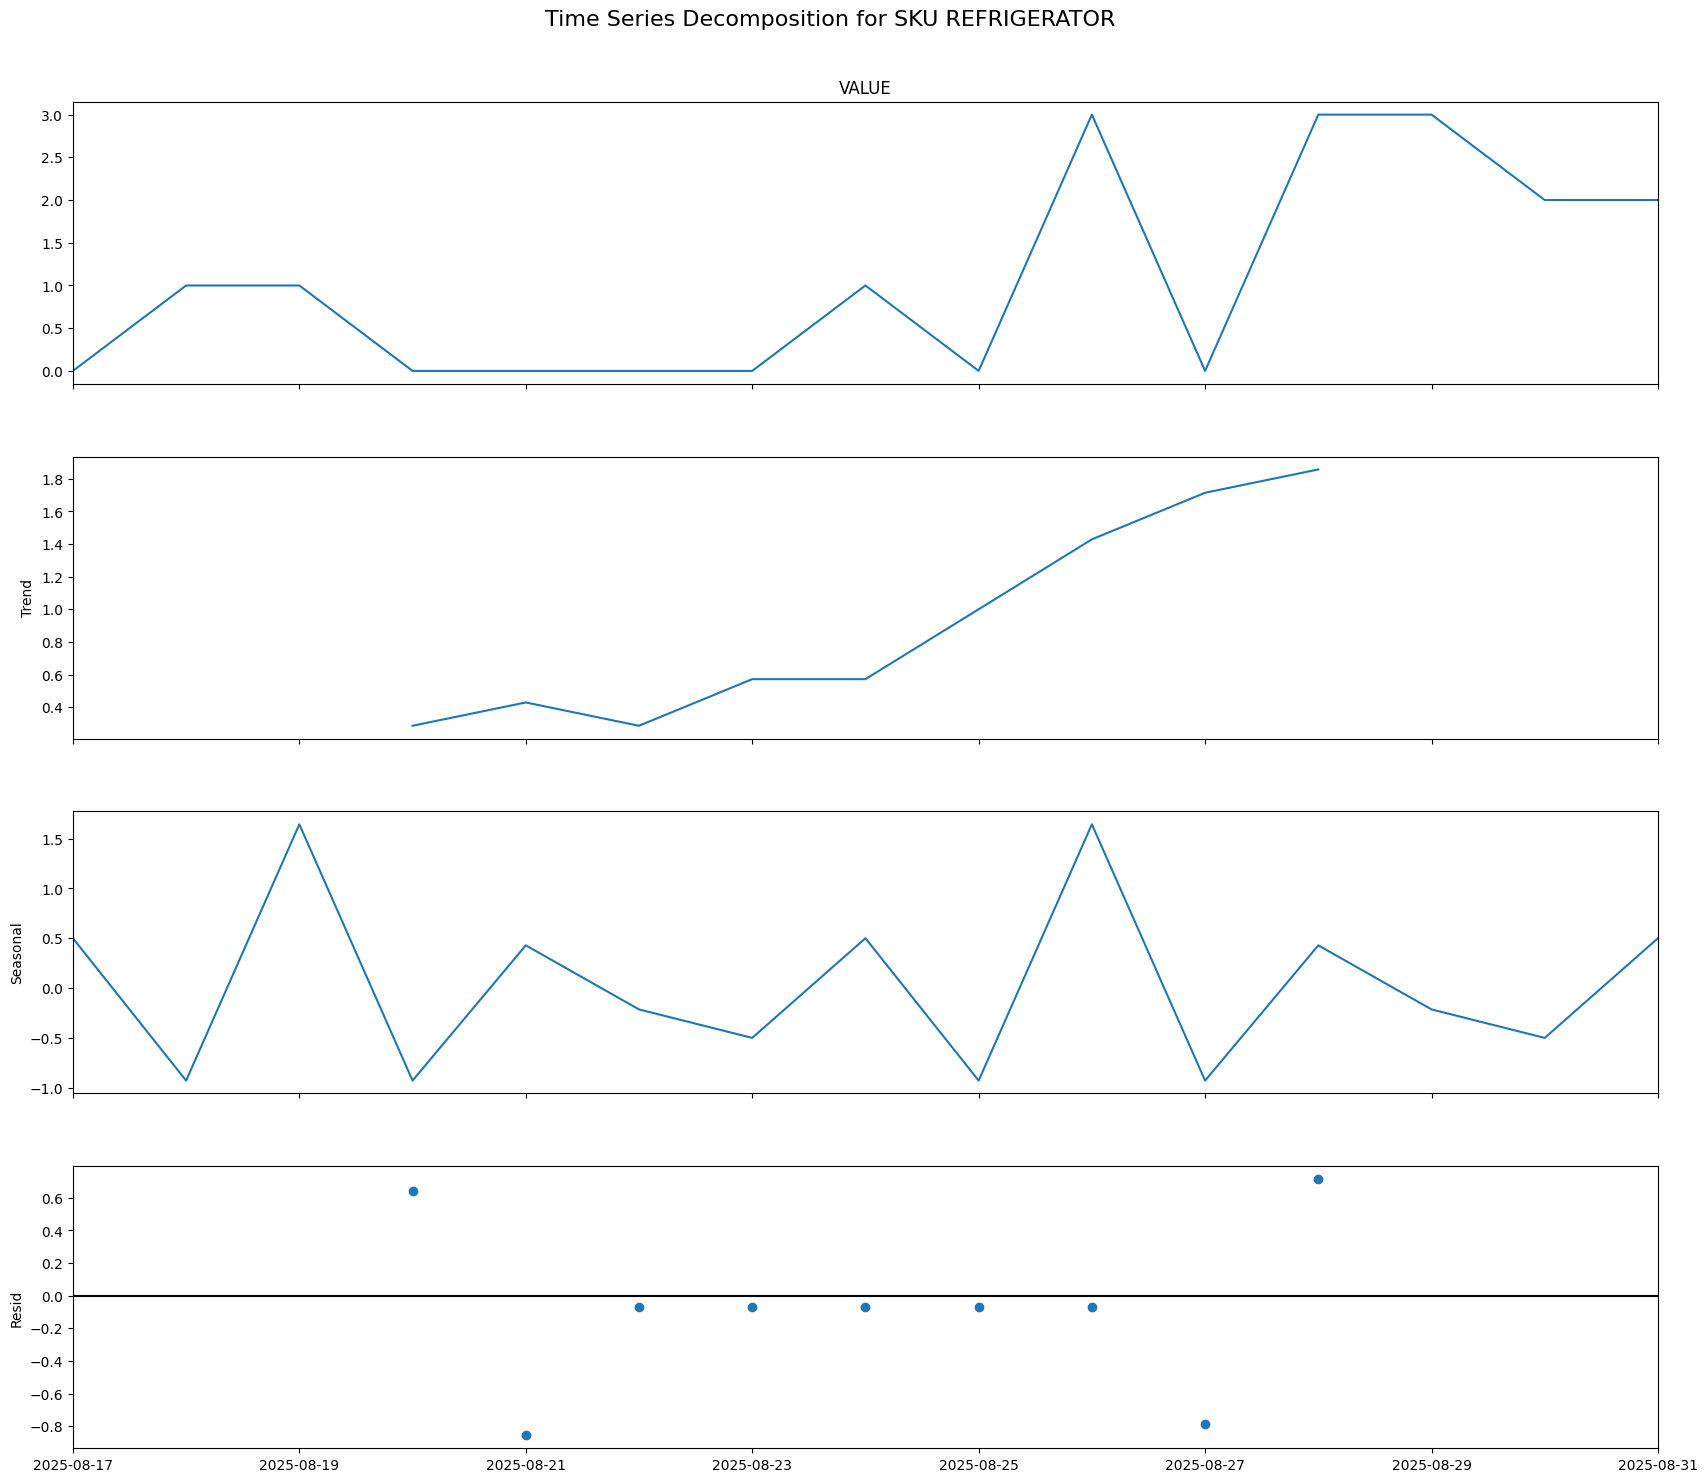

In [962]:
for col in df['NAME'].unique():
    decompose_sku_timeseries(df, col)

### Zero Share

1. ENERGY_T is the most problematic SKU, with zero demand on approximately 81% of days - meaning it only sells on about 1 in 5 days.
2. REFRIGERATOR follows at around 47% zero-demand days, selling roughly every other day.

3. DISHWASHER, DRYER, and MICROWAVE appear to have the most consistent demand with no zero days.
4. Other SKUs have moderate zero share

In [964]:
def plot_zs_top(zero_share):
  top = zero_share.sort_values("zero_share", ascending=False)
  plt.figure(figsize=(12,8))
  sns.barplot(x="NAME", y="zero_share", data=top)
  plt.title("Top SKUs with Most Zero-Demand Days")
  plt.xlabel("SKU")
  plt.ylabel("Fraction of zero-demand days")
  plt.xticks(rotation=45)
  plt.show()


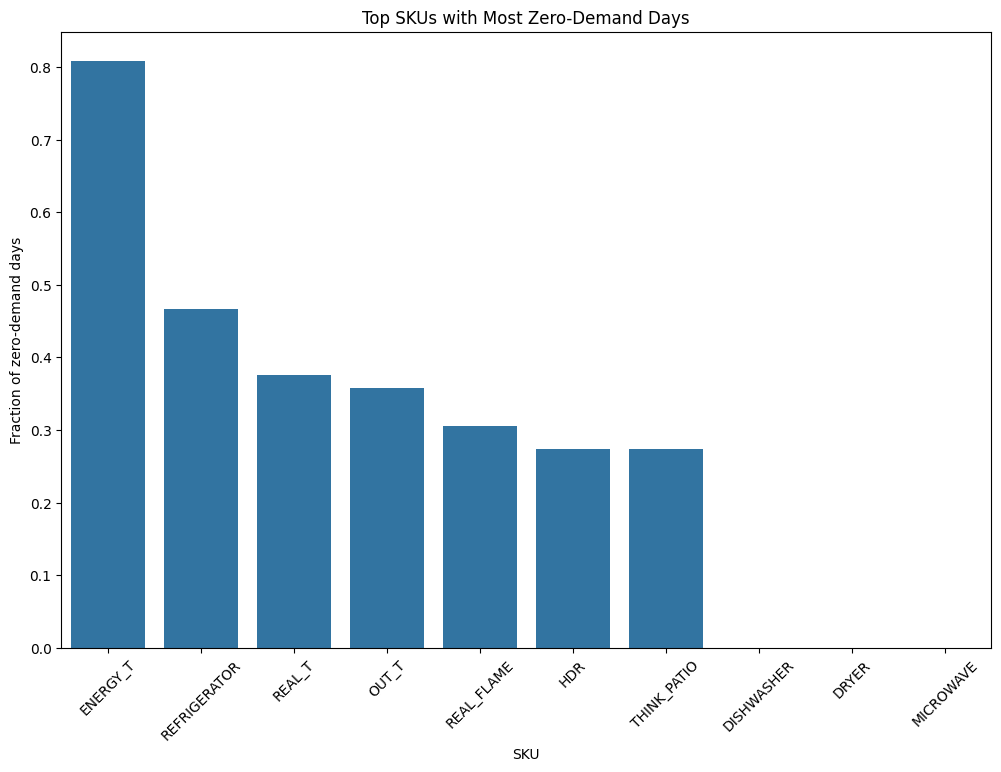

In [966]:


# Compute zero-demand fraction per SKU
zero_share = (
    df.groupby("NAME")["VALUE"]
      .apply(lambda x: (x==0).mean())
      .reset_index(name="zero_share")
)


plot_zs_top(zero_share)


### Distribution

1. High-Volume, Low-Value Items:

REAL_T, REAL_FLAME: Extremely concentrated around low values (0-5 range), suggesting these are low-priced, high-frequency items
HDR: Similar pattern but slightly more spread

2. Mid-Range Consumer Products:

THINK_RATIO: Most interesting distribution - relatively flat across a wide range (0-50), indicating diverse pricing tiers or bundling strategies
ENERGY_T: Concentrated in low range but with some higher-value transactions
OUT_T: Moderate spread, typical consumer product pattern

3. High-Value Appliances:

MICROWAVE, DISHWASHER, DRYER: All show concentrated distributions in higher value ranges, consistent with appliance pricing
REFRIGERATOR: Unique bimodal distribution with peaks around 1.0 and 3.5, suggesting two distinct product lines (compact vs. full-size, or different brands)

In [970]:
def plot_sku_distributions(df, sku_col="NAME", target_col="VALUE", kind="hist", bins=20):

    unique_skus = df[sku_col].unique()
    n_skus = len(unique_skus)

    fig, axes = plt.subplots(n_skus, 1, figsize=(8, 4*n_skus))

    if n_skus == 1:
        axes = [axes]

    for ax, sku in zip(axes, unique_skus[:n_skus]):
        sku_data = df[df[sku_col] == sku][target_col]

        if kind == "hist":
            sns.histplot(sku_data, bins=bins, kde=False, ax=ax, color="skyblue")
        elif kind == "kde":
            sns.kdeplot(sku_data, ax=ax, fill=True, color="orange")

        ax.set_title(f"Distribution of {target_col} for SKU {sku}")
        ax.set_xlabel(target_col)
        ax.set_ylabel("Frequency" if kind=="hist" else "Density")

    plt.tight_layout()
    plt.show()


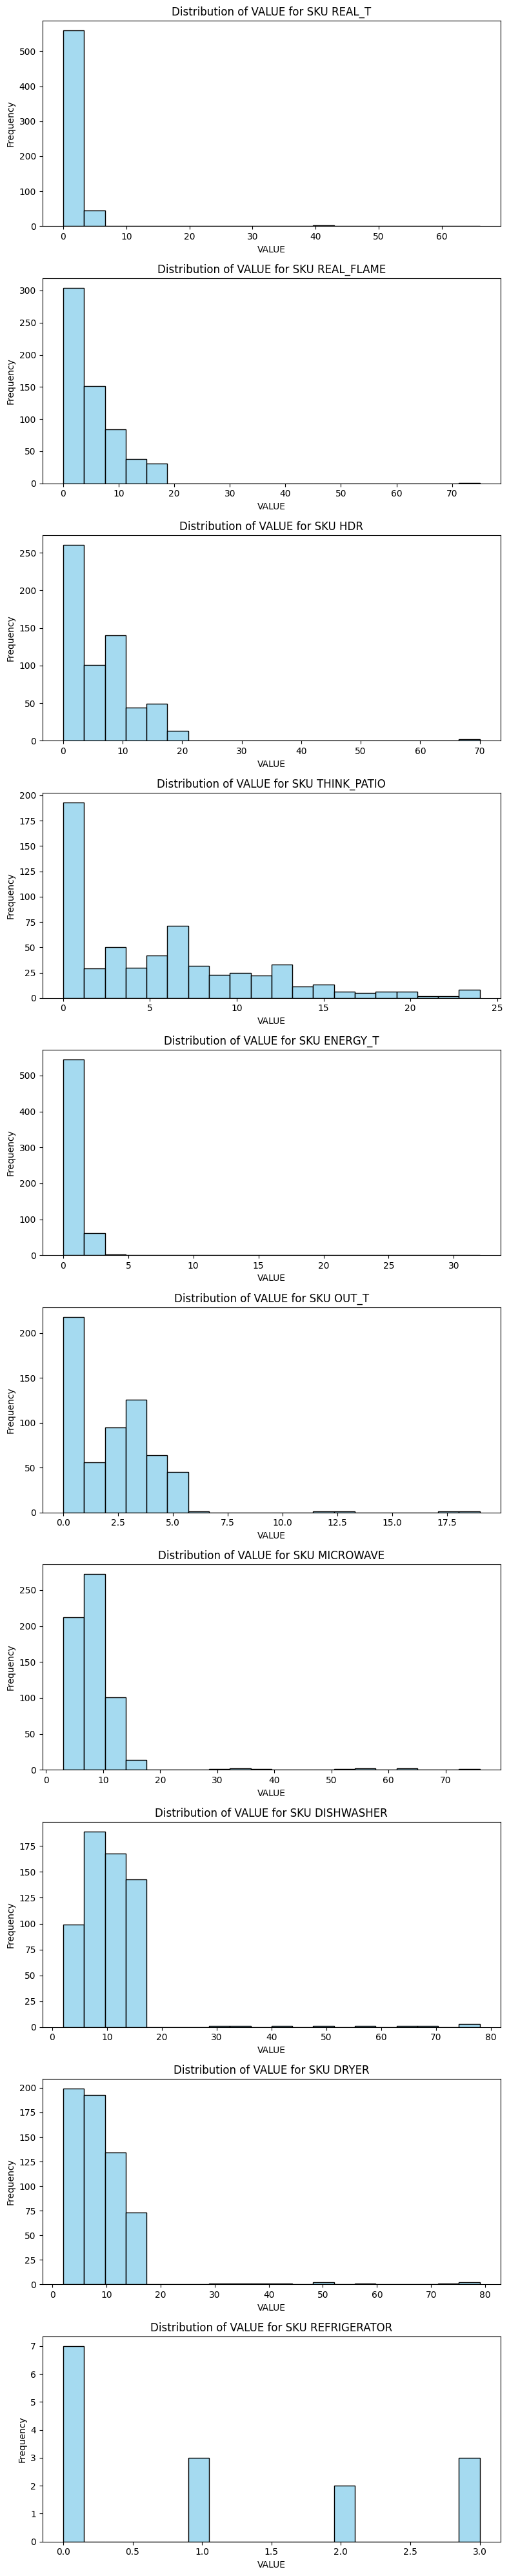

In [971]:
plot_sku_distributions(df)

### Yearly Seasonality


In [968]:
def plot_yearly_seasonality(df, name):
    ts = df[df['NAME'] == name].copy()
    ts['Month'] = ts['DATE'].dt.month_name()
    monthly_avg = ts.groupby('Month')['VALUE'].mean()

    # Reorder months
    months_order = ["January","February","March","April","May","June",
                    "July","August","September","October","November","December"]
    monthly_avg = monthly_avg.reindex(months_order)

    plt.figure(figsize=(8,4))
    monthly_avg.plot(kind='bar', color='orange')
    plt.title(f"Yearly Seasonality (Avg Sales by Month): {name}")
    plt.ylabel("Average Sales")
    plt.show()


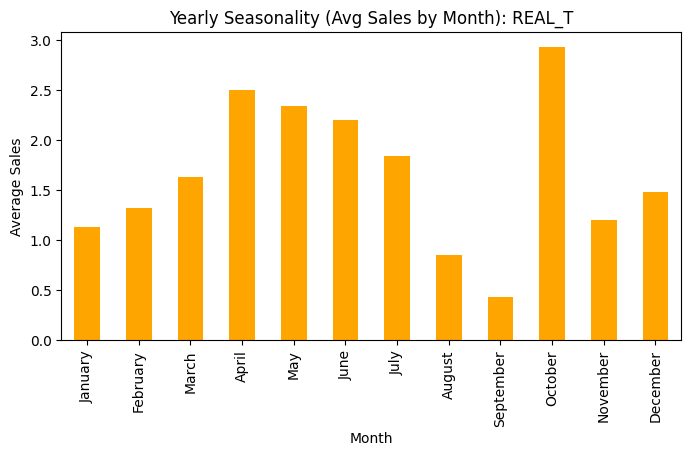

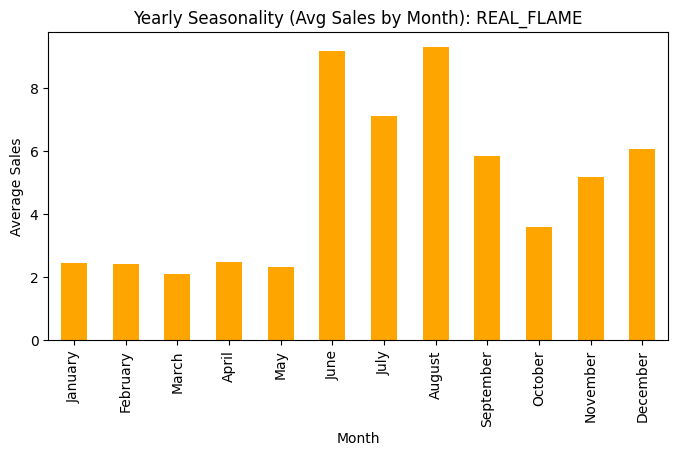

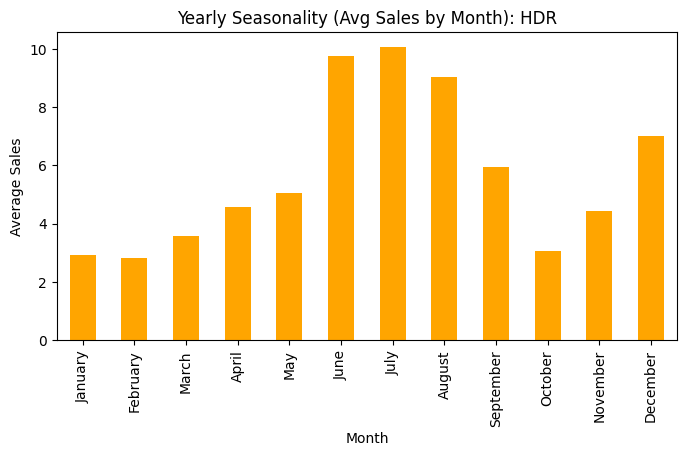

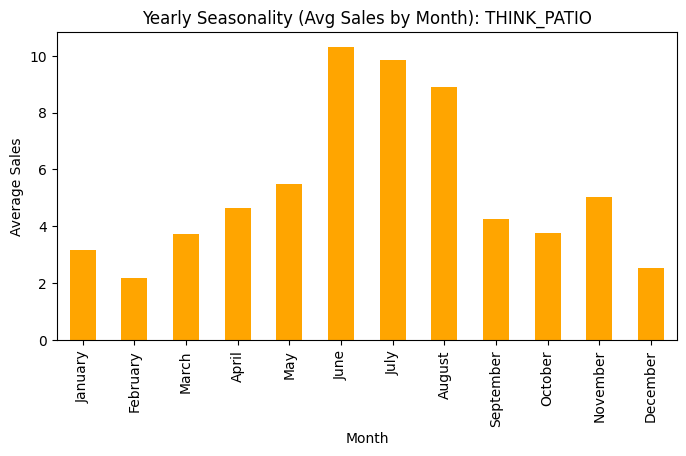

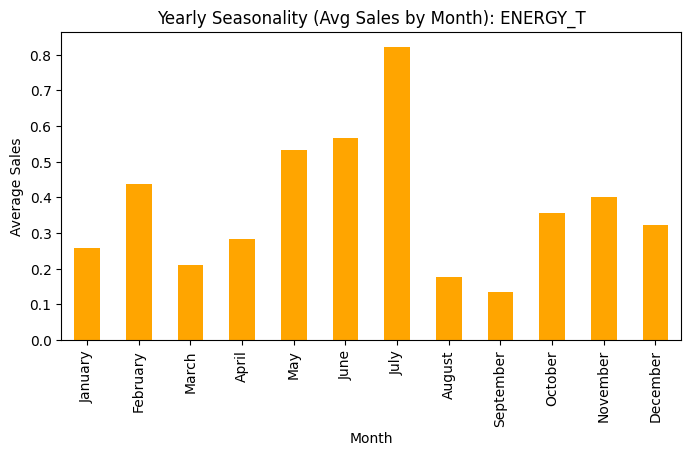

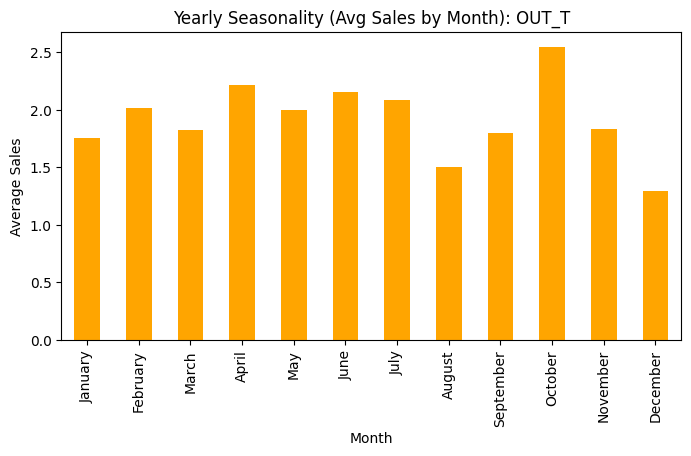

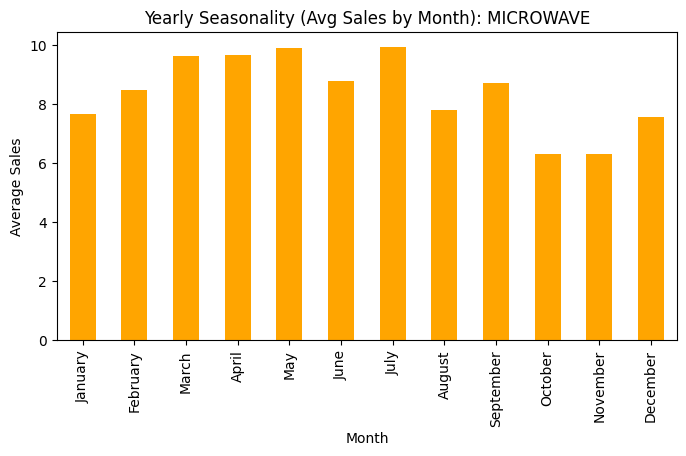

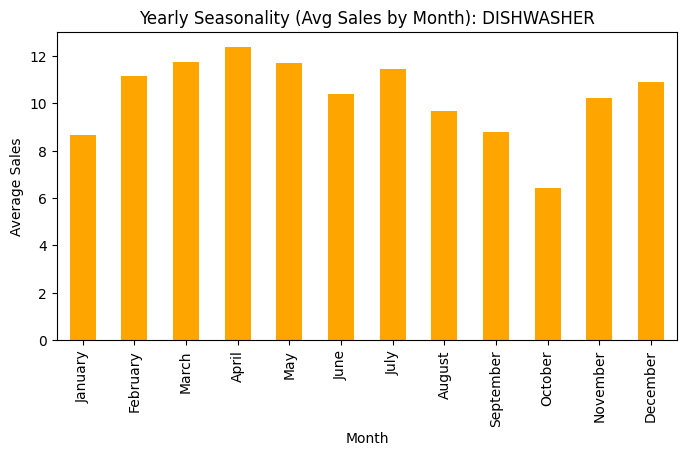

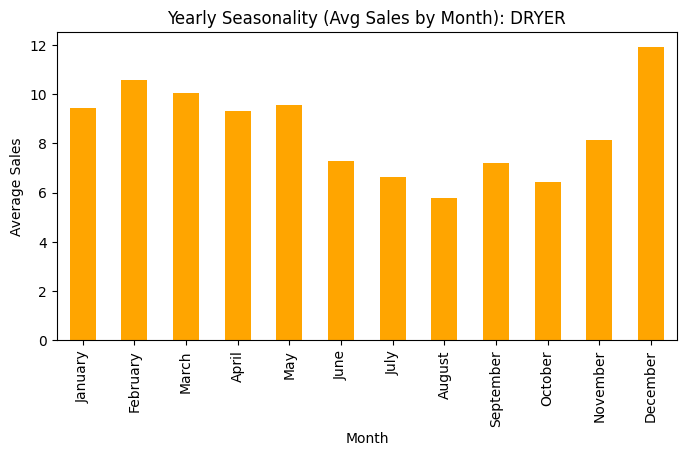

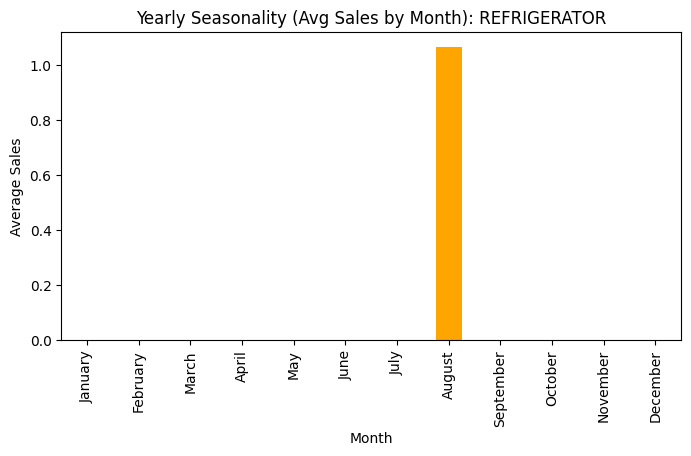

In [969]:
for col in df["NAME"].unique():
  plot_yearly_seasonality(df, col)

# Preprocessing



Outlier Handling Strategy:

1. Intermittent SKUs (991234-A, 121987-A): No outlier handling, since occasional zeros or spikes are expected and informative.

2. Erratic, non-seasonal SKUs (111934-A, 121234-A, 177714-A): Use capping to constrain extreme spikes while preserving overall patterns.

3. Seasonal SKUs (all others): Use winsorization to moderate extremes without removing natural seasonal variations.

In [915]:
skus = df[['ITEM_CODE', 'NAME', 'GROUP']].drop_duplicates()
sku_list = list(zip(skus['ITEM_CODE'], skus['NAME'],skus['GROUP']))
print(f"Found {len(sku_list)} unique SKUs")
for item_code, name, group in sku_list:
    print(f"  {item_code} - {name}-{group}")


Found 10 unique SKUs
  111900-A - REAL_T-THERMOSTATS
  111934-A - REAL_FLAME-HEATING
  121234-A - HDR-HEATING
  121914-A - THINK_PATIO-HEATING
  121987-A - ENERGY_T-THERMOSTATS
  177714-A - OUT_T-THERMOSTATS
  261514-A - MICROWAVE-APPLIANCES
  561934-A - DISHWASHER-APPLIANCES
  661914-A - DRYER-APPLIANCES
  991234-A - REFRIGERATOR-APPLIANCES


In [916]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5496 entries, 0 to 5495
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       5496 non-null   datetime64[ns]
 1   VALUE      5496 non-null   int64         
 2   ITEM_CODE  5496 non-null   object        
 3   NAME       5496 non-null   object        
 4   GROUP      5496 non-null   object        
 5   NOTES      15 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 257.8+ KB


In [917]:
df.describe()

DATE        VALUE
count                           5496  5496.000000
mean   2024-10-31 19:27:14.934498304     5.312227
min              2024-01-01 00:00:00     0.000000
25%              2024-06-01 00:00:00     0.000000
50%              2024-11-01 00:00:00     4.000000
75%              2025-04-02 06:00:00     8.000000
max              2025-08-31 00:00:00    79.000000
std                              NaN     6.478441

In [918]:
def check_sku_data(df,skus,sku_list):

  summaries = []
  summary_df = pd.DataFrame(columns=['name', 'group', 'records', 'date_range', 'missing_values', 'negative_values', 'zero_count', 'zero_share', 'mean_value', 'std_value', 'min_value', 'max_value'])
  # Check each SKU
  for item_code, name, group  in sku_list:
      sku_data = df[df['ITEM_CODE'] == item_code]

      sku_summary = {
          'name': name,
          'group': group,
          'records': int(len(sku_data)),
          'start_date': str(sku_data['DATE'].min()),
          'end_date': str(sku_data['DATE'].max()),
          'missing_values': sku_data.isnull().sum(),
          'negative_values': int((sku_data['VALUE'] < 0).sum()),
          'zero_count': int((sku_data['VALUE'] == 0).sum()),
          'perc_zero_share': float((sku_data['VALUE'] == 0).sum() / len(sku_data)) * 100,
          'mean_value': float(sku_data['VALUE'].mean()) ,
          'std_value': float(sku_data['VALUE'].std()) ,
          'min_value': int(sku_data['VALUE'].min()),
          'max_value': int(sku_data['VALUE'].max())
      }
      summaries.append(sku_summary)

  summary_df = pd.DataFrame(summaries)

  # sku_summary_df = pd.DataFrame.from_dict(sku_summary, orient='index')


  return summary_df

In [919]:
check_sku_data(df,skus,sku_list)

name        group  records           start_date  \
0        REAL_T  THERMOSTATS      609  2024-01-01 00:00:00   
1    REAL_FLAME      HEATING      609  2024-01-01 00:00:00   
2           HDR      HEATING      609  2024-01-01 00:00:00   
3   THINK_PATIO      HEATING      609  2024-01-01 00:00:00   
4      ENERGY_T  THERMOSTATS      609  2024-01-01 00:00:00   
5         OUT_T  THERMOSTATS      609  2024-01-01 00:00:00   
6     MICROWAVE   APPLIANCES      609  2024-01-01 00:00:00   
7    DISHWASHER   APPLIANCES      609  2024-01-01 00:00:00   
8         DRYER   APPLIANCES      609  2024-01-01 00:00:00   
9  REFRIGERATOR   APPLIANCES       15  2025-08-17 00:00:00   

              end_date                                     missing_values  \
0  2025-08-31 00:00:00  DATE           0
VALUE          0
ITEM_CODE   ...   
1  2025-08-31 00:00:00  DATE           0
VALUE          0
ITEM_CODE   ...   
2  2025-08-31 00:00:00  DATE           0
VALUE          0
ITEM_CODE   ...   
3  2025-08-31 00:00:00  DATE           0
VALUE          0
ITEM_CODE   ...   
4  2025-08-31 00:00:00  DATE           0
VALUE          0
ITEM_CODE   ...   
5  2025-08-31 00:00:00  DATE           0
VALUE          0
ITEM_CODE   ...   
6  2025-08-31 00:00:00  DATE           0
VALUE          0
ITEM_CODE   ...   
7  2025-08-31 00:00:00  DATE           0
VALUE          0
ITEM_CODE   ...   
8  2025-08-31 00:00:00  DATE           0
VALUE          0
ITEM_CODE   ...   
9  2025-08-31 00:00:00  DATE         0
VALUE        0
ITEM_CODE    0
N...   

   negative_values  zero_count  perc_zero_share  mean_value  std_value  \
0                0         229        37.602627    1.684729   4.398241   
1                0         186        30.541872    4.776683   5.564164   
2                0         167        27.422003    5.825944   6.401525   
3                0         167        27.422003    5.628900   5.576639   
4                0         492        80.788177    0.389163   1.501517   
5                0         218        35.796388    1.926108   2.025201   
6                0           0         0.000000    8.620690   6.382720   
7                0           0         0.000000   10.525452   7.537391   
8                0           0         0.000000    8.536946   7.372537   
9                0           7        46.666667    1.066667   1.222799   

   min_value  max_value  
0          0         66  
1          0         75  
2          0         70  
3          0         24  
4          0         32  
5          0         19  
6          3         76  
7          2         78  
8          2         79  
9          0          3

In [920]:


def handle_outliers(data, method, outlier_info=None):

    data_processed = data.copy()

    if method == 'winsorize':
        # Winsorize outliers to 5th and 95th percentiles
        lower_percentile = data.quantile(0.05)
        upper_percentile = data.quantile(0.95)

        data_processed = np.where(
            data_processed < lower_percentile,
            lower_percentile,
            data_processed
        )
        data_processed = np.where(
            data_processed > upper_percentile,
            upper_percentile,
            data_processed
        )

    elif method == 'cap':
        if not outlier_info or 'lower_bound' not in outlier_info or 'upper_bound' not in outlier_info:
            raise ValueError("outlier_info must be a dictionary with 'lower_bound' and 'upper_bound' for the 'cap' method.")

        data_processed = np.where(
            data_processed < outlier_info['lower_bound'],
            outlier_info['lower_bound'],
            data_processed
        )
        data_processed = np.where(
            data_processed > outlier_info['upper_bound'],
            outlier_info['upper_bound'],
            data_processed
        )

    return pd.Series(data_processed.astype(int), index=data.index)

In [921]:
def detect_outliers(data,factor=1.5):

      Q1 = data.quantile(0.25)
      Q3 = data.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - factor * IQR
      upper_bound = Q3 + factor * IQR
      outliers = (data < lower_bound) | (data > upper_bound)


      outlier_info = {
          'factor': factor,
          'outlier_count': int(outliers.sum()),
          'outlier_percentage': float(outliers.sum() / len(data) * 100),
          'outlier_indices': data[outliers].index.tolist(),
          'outlier_values': data[outliers].values.tolist(),
          'Q1': float(Q1),
          'Q3': float(Q3),
          'IQR': float(IQR),
          'lower_bound': float(lower_bound),
          'upper_bound': float(upper_bound)
      }

      return outlier_info

In [922]:
def preprocess(df, item_code,train_start=TRAIN_START,train_end=TRAIN_END):

  print(f"Processing SKU: {item_code}")

  # Filter SKU data
  sku_data = df[df['ITEM_CODE'] == item_code].copy()

  sku_data['DATE'] = pd.to_datetime(sku_data['DATE'])

  train_start = pd.Timestamp(TRAIN_START)
  train_end = pd.Timestamp(TRAIN_END)

  sku_data = sku_data.sort_values('DATE').reset_index(drop=True)

  # Filter based on training period in case of more data
  sku_data = sku_data[(sku_data['DATE'] >= train_start) & (sku_data['DATE'] <= train_end)].copy()
  print(f"Filtered {len(sku_data)} records for {item_code}")

  # Detect outliers
  outlier_info = detect_outliers(sku_data['VALUE'],factor=1.5)

  # Handle outliers
  if item_code in ['991234-A','121987-A']: # Intermittent demand does not require outlier removal
    print(f"No need to handle outliers for {item_code}")

  elif item_code in ['111934-A','121234-A','177714-A']: # Erratic spikes with no visibile seasonality

    sku_data['VALUE_ORIGINAL'] = sku_data['VALUE'].copy()
    sku_data['VALUE'] = handle_outliers(sku_data['VALUE'], method='cap', outlier_info=outlier_info)

  else: # For outliers which look seasonal winsorize to make it moderate
    sku_data['VALUE_ORIGINAL'] = sku_data['VALUE'].copy()
    sku_data['VALUE'] = handle_outliers(sku_data['VALUE'], method='winsorize', outlier_info=None)

  # Calculate zero share
  zero_share = (sku_data['VALUE'] == 0).sum() / len(sku_data)


  print(f"Processed {len(sku_data)} records for {item_code}")
  print(f"Zero share: {zero_share:.3f}")
  print(f"Outliers detected: {outlier_info['outlier_count']} ({outlier_info['outlier_percentage']:.1f}%)")

  return sku_data

In [923]:
# Get preprocessed dataframes
preprocessed_dataframes = {}
for item_code in df['ITEM_CODE'].unique():
    preprocessed_dataframes[item_code] = preprocess(df, item_code)


Processing SKU: 111900-A
Filtered 609 records for 111900-A
Processed 609 records for 111900-A
Zero share: 0.376
Outliers detected: 5 (0.8%)
Processing SKU: 111934-A
Filtered 609 records for 111934-A
Processed 609 records for 111934-A
Zero share: 0.305
Outliers detected: 1 (0.2%)
Processing SKU: 121234-A
Filtered 609 records for 121234-A
Processed 609 records for 121234-A
Zero share: 0.274
Outliers detected: 2 (0.3%)
Processing SKU: 121914-A
Filtered 609 records for 121914-A
Processed 609 records for 121914-A
Zero share: 0.274
Outliers detected: 8 (1.3%)
Processing SKU: 121987-A
Filtered 609 records for 121987-A
No need to handle outliers for 121987-A
Processed 609 records for 121987-A
Zero share: 0.808
Outliers detected: 117 (19.2%)
Processing SKU: 177714-A
Filtered 609 records for 177714-A
Processed 609 records for 177714-A
Zero share: 0.358
Outliers detected: 4 (0.7%)
Processing SKU: 261514-A
Filtered 609 records for 261514-A
Processed 609 records for 261514-A
Zero share: 0.000
Outli

In [924]:
preprocessed_dataframes['561934-A']

DATE  VALUE ITEM_CODE        NAME       GROUP NOTES  VALUE_ORIGINAL
0   2024-01-01     11  561934-A  DISHWASHER  APPLIANCES   NaN              11
1   2024-01-02      3  561934-A  DISHWASHER  APPLIANCES   NaN               3
2   2024-01-03      6  561934-A  DISHWASHER  APPLIANCES   NaN               6
3   2024-01-04      3  561934-A  DISHWASHER  APPLIANCES   NaN               3
4   2024-01-05     12  561934-A  DISHWASHER  APPLIANCES   NaN              12
..         ...    ...       ...         ...         ...   ...             ...
604 2025-08-27     14  561934-A  DISHWASHER  APPLIANCES   NaN              14
605 2025-08-28      7  561934-A  DISHWASHER  APPLIANCES   NaN               7
606 2025-08-29      6  561934-A  DISHWASHER  APPLIANCES   NaN               6
607 2025-08-30     12  561934-A  DISHWASHER  APPLIANCES   NaN              12
608 2025-08-31     15  561934-A  DISHWASHER  APPLIANCES   NaN              15

[609 rows x 7 columns]

# Feature Engineering

Categorical Encoding

1. GROUP - group_encoded using LabelEncoder. Converts categorical SKU group information into numeric form for ML models.

2. Trend & Momentum Features -
   * trend: linear sequence over time to capture long-term growth or decline.* * momentum_{1,3,7}: short-term changes to capture recent spikes or drops.

    Helps models detect underlying trends and recent directional changes.

3.  Rolling Statistics -
    * Rolling mean, median, std, variance, min, max over multiple windows (7, 15, 30, 60 days).
    * Captures short- and medium-term patterns and volatility in the series.

4. Lag Features - Lag values, differences, and ratios for 7, 14, 28 days
    Provides historical context for the model, allowing it to learn temporal dependencies.

5. Level Shift Features -
    Difference from rolling mean and detection of     significant shifts (above 2σ).Captures abrupt changes or structural breaks in the series, which can indicate new demand regimes.

6. Calendar Features -

    Day, month, day of week, day of year, and cyclical encodings (sin/cos) for day/week/month/year.Weekend, month-end, and summer indicators.Captures seasonality, cyclical patterns that influence demand.

In [925]:
def create_calendar_features(df):

    # Standard Calendar Features
    df['dayofweek'] = df['DATE'].dt.dayofweek
    df['month'] = df['DATE'].dt.month
    df['day'] = df['DATE'].dt.day
    df['dayofyear'] = df['DATE'].dt.dayofyear

    # Cyclical encoding for day of week (to imply that Sunday and Monday are close etc.)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Cyclical encoding for month of year (to imply that Jan and Dec are close etc.)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Cyclical encoding for day of year (to imply that 360 and 1 are close)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)

    # Weekend indicator (Saturday/Sunday = 1)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Month-end indicator (days 28-31 = 1)
    df['is_month_end'] = (df['day'] >= 28).astype(int)

    # Summer indicator
    df['is_summer'] = ((df['month'] >= 3) & (df['month'] <= 9)).astype(int)

    return df

In [926]:
def create_level_shift_features(df, value_col='VALUE'):

    # Rolling mean for level shift detection
    df['rolling_mean_30'] = df[value_col].rolling(window=30, min_periods=1).mean()
    df['rolling_mean_60'] = df[value_col].rolling(window=60, min_periods=1).mean()

    # Level shift indicators
    df['level_shift_30'] = (df[value_col] - df['rolling_mean_30'].shift(1)).abs()
    df['level_shift_60'] = (df[value_col] - df['rolling_mean_60'].shift(1)).abs()

    # Significant level shift (above 2 standard deviations)
    level_shift_std = df['level_shift_30'].std()
    df['significant_level_shift'] = (df['level_shift_30'] > 2 * level_shift_std).astype(int)

    return df


In [927]:
def create_lag_features(df, value_col='VALUE', lags=[7, 14, 28]):
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')

    for lag in lags:
        lag_col = f'lag_{lag}'
        df[lag_col] = df[value_col].shift(lag).astype(float)
        df[f'lag_diff_{lag}'] = df[value_col] - df[lag_col]
        df[f'lag_ratio_{lag}'] = df[value_col] / (df[lag_col] + 1e-8)

    df.fillna(0, inplace=True)  # for short histories
    return df

In [928]:
def create_rolling_features(df, value_col='VALUE', windows=[7, 15, 30, 60]):

  for window in windows:
      # Only keep specified rolling statistics
      df[f'rolling_mean_{window}'] = df[value_col].rolling(window=window, min_periods=1).mean()
      df[f'rolling_median_{window}'] = df[value_col].rolling(window=window, min_periods=1).median()
      df[f'rolling_std_{window}'] = df[value_col].rolling(window=window, min_periods=1).std()
      df[f'rolling_var_{window}'] = df[value_col].rolling(window=window, min_periods=1).var()
      df[f'rolling_min_{window}'] = df[value_col].rolling(window=window, min_periods=1).min()
      df[f'rolling_max_{window}'] = df[value_col].rolling(window=window, min_periods=1).max()

  return df

In [929]:
def create_trend_features(df, value_col='VALUE'):

    # Linear trend
    df['trend'] = np.arange(len(df))

    # Momentum features for short-term patterns
    for window in [1, 3, 7]:
        df[f'momentum_{window}'] = df[value_col] - df[value_col].shift(window)

    return df

In [930]:
def create_group_encoding(df):

    # Label encode the GROUP column
    # Ensure the column is of string type before encoding
    df['GROUP'] = df['GROUP'].astype(str)
    le = LabelEncoder()
    df['group_encoded'] = le.fit_transform(df['GROUP'])

    return df

In [931]:
def engineer_features_for_sku(item_code, sku_data):

    df = sku_data.copy()

    # Create enhanced feature categories
    df = create_calendar_features(df)
    df = create_level_shift_features(df)
    df = create_lag_features(df, lags=[7, 14, 28])
    df = create_rolling_features(df, windows=[7, 15, 30, 60])
    df = create_trend_features(df)
    df = create_group_encoding(df)

    # Handle missing values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)

    # Remove infinite values
    df = df.replace([np.inf, -np.inf], 0)

    print(f"Created {len(df.columns)} enhanced features for {item_code}")

    return df


In [932]:
feat_eng_df ={}
for item_code, sku_data in preprocessed_dataframes.items():
    feat_eng_df[item_code] = engineer_features_for_sku(item_code, sku_data)

Created 61 enhanced features for 111900-A
Created 61 enhanced features for 111934-A
Created 61 enhanced features for 121234-A
Created 61 enhanced features for 121914-A
Created 60 enhanced features for 121987-A
Created 61 enhanced features for 177714-A
Created 61 enhanced features for 261514-A
Created 61 enhanced features for 561934-A
Created 61 enhanced features for 661914-A
Created 60 enhanced features for 991234-A


# Splitting



1. Test Set : Always takes the last 20 days of the SKU’s data.

2. Validation Set : For SKUs with moderate or low zero share, the validation set is the 20 to 40 days before the test window. For SKUs with high zero share, only a minimal split is made (last 20 or 2 days as test depending on duration, no validation) for Zero Share and Croston

3. Training Set :Remaining historical data prior to the validation window.
If no validation is used (high zero-share SKUs or very short series), training includes all data before the test set.

In [933]:
# Calculate zero share of the series
def calculate_zero_share(data):
        return (data['VALUE'] == 0).sum() / len(data)

In [934]:
from datetime import timedelta

def split_sku_data(item_code, sku_data):

    zero_share = calculate_zero_share(sku_data)
    print(f"Splitting data for {item_code} with zero share={zero_share}")


    # Define test window
    end_date = sku_data['DATE'].max()
    test_start_date = end_date - timedelta(days=20)

    # Test data = last 20 days
    test_data = sku_data[sku_data['DATE'] >= test_start_date].copy()
    remaining = sku_data[sku_data['DATE'] < test_start_date].copy()

    if zero_share < MEDIUM_ZERO_THRESHOLD:
        # Validation cutoff (e.g., last 40-20 days before test)
        val_start_date = test_start_date - timedelta(days=40)

        val_data = remaining[remaining['DATE'] >= val_start_date].copy()
        train_data = remaining[remaining['DATE'] < val_start_date].copy()

    elif len(sku_data)<=20:
        train_data = sku_data.iloc[:-2].copy()
        val_data = None
        test_data = sku_data.iloc[-2:].copy()
    else:

        train_data = remaining.copy()
        val_data = None

    print(f"Split: {len(train_data)} train, {len(val_data) if val_data is not None else 0} val, {len(test_data)} test")

    return train_data, val_data, test_data


In [935]:
modelling_df = {}

for item_code, sku_data in feat_eng_df.items():
    train_data, val_data, test_data = split_sku_data(item_code, sku_data)
    modelling_df[item_code] = {"train":train_data,"val":val_data,"test":test_data}

Splitting data for 111900-A with zero share=0.3760262725779967
Split: 548 train, 40 val, 21 test
Splitting data for 111934-A with zero share=0.3054187192118227
Split: 548 train, 40 val, 21 test
Splitting data for 121234-A with zero share=0.2742200328407225
Split: 548 train, 40 val, 21 test
Splitting data for 121914-A with zero share=0.2742200328407225
Split: 548 train, 40 val, 21 test
Splitting data for 121987-A with zero share=0.8078817733990148
Split: 588 train, 0 val, 21 test
Splitting data for 177714-A with zero share=0.3579638752052545
Split: 548 train, 40 val, 21 test
Splitting data for 261514-A with zero share=0.0
Split: 548 train, 40 val, 21 test
Splitting data for 561934-A with zero share=0.0
Split: 548 train, 40 val, 21 test
Splitting data for 661914-A with zero share=0.0
Split: 548 train, 40 val, 21 test
Splitting data for 991234-A with zero share=0.4666666666666667
Split: 13 train, 0 val, 2 test


# Training

## Utility Functions

In [936]:
# Select model based on zero share
def select_model_type(zero_share,data):
  if zero_share < LOW_ZERO_THRESHOLD:
    return 'xgboost'
  elif zero_share < MEDIUM_ZERO_THRESHOLD:
    return 'ensemble'
  else:
    if len(data) > 30:
      return 'zero_inflated'
    else:
      return 'croston'

In [937]:
# Features used vary by model
def prepare_features(data,model_type):

  # Exclude index, target and identifiers(item code, name), group (encoded separately), notes (too many null values)
  exclude_cols = ['DATE', 'VALUE', 'VALUE_ORIGINAL', 'ITEM_CODE', 'NAME', 'GROUP','NOTES']

  if model_type in ['xgboost','ensemble']:
      feature_cols = [col for col in data.columns if col not in exclude_cols]

  # Croston model is univariate and only takes historical values of the target itself
  elif model_type == 'croston':
      feature_cols = ['VALUE']

  # For the zero share model we use a subset of the features to prevent noise
  else:
      feature_cols = [col for col in ZERO_SHARE_FEATS if col not in exclude_cols]

  # Fill null values such as from lags etc to 0
  X = data[feature_cols].fillna(0)
  y = data['VALUE']

  return X, y, feature_cols

## Models

1. Models are selected per SKU based on their zero share
    a. If the zero-share is > 0.4 and historical data duration > 30 : Zero Inflated model is used.
    b. If the zero-share is > 0,4 and historical data duration <30 : Croston's model is used
    c. If the zero-share is >0.2 and <0.4 : Ensemble model (XGBoost + LightGBM) is used
    d. If the zero-share is <0.2: XGBoost is used

2. Model Choices Reasoning:

    a. High zero-share series are intermittent. Zero-Inflated models handle excess zeros statistically when sufficient history exists, while Croston’s method is effective for short intermittent series.

    b. Moderate zero-share series benefit from Ensemble ML models capturing non-linear patterns and complex dependencies while XGBoost is sufficient when zeros are rare. Both these models are less prone to outliers as well

3. Loss Function - MAE is used for training the ML models since the data has outliers and MAE is  more robust


4. Evaluation Metrics:
  The models are evaluated using MAE, MSE, RMSE, R², and MAPE. However, MAPE can be misleading or extremely large for series with many zero values, since dividing by zero (or near-zero) inflates the percentage error. For intermittent demand series, MAE and RMSE are more reliable indicators of performance.

In [938]:
xgboost_params ={
      'n_estimators': 200,
      'max_depth': 6,
      'learning_rate': 0.01,
      'subsample': 0.9,
      'colsample_bytree': 0.9
  }

xgboost_loss = 'mae'

In [939]:

def train_xgboost_model(X_train, y_train, X_val, y_val,params=xgboost_params,loss=xgboost_loss):

  print("Training XGBoost model...")

  model = XGBRegressor(**params,objective='reg:absoluteerror',random_state=42, n_jobs=-1, verbosity=1)

  model.fit( X_train, y_train,eval_set=[(X_train, y_train), (X_val, y_val)],verbose=False)

  # Extract training history
  train_loss = model.evals_result_['validation_0'][loss]
  val_loss = model.evals_result_['validation_1'][loss]

  loss_history = {
      'train_loss': train_loss,
      'val_loss': val_loss,
      'epochs': list(range(1, len(train_loss) + 1))
  }

  print(f"XGBoost training completed with params: {params}")

  return model, params, loss_history

In [940]:
ensemble_lgbm_params = {
            'n_estimators':200,
            'max_depth':6,
            'learning_rate':0.01,
            'subsample':0.9,
            'colsample_bytree':0.9
            }



In [941]:
def train_ensemble_model(X_train, y_train, X_val, y_val,loss='l1'):

  print("Training ensemble model (XGBoost + LightGBM)...")

  # Train XGBoost
  xgb_model, xgb_params, xgb_loss_history = train_xgboost_model(X_train, y_train, X_val, y_val)

  # Train LightGBM
  lgb_model = LGBMRegressor(
      **ensemble_lgbm_params,
      random_state=42,
      verbosity=-1,
      objective='regression_l1' # Corrected objective function name
  )

  lgb_model.fit(
      X_train, y_train,
      eval_set=[(X_train, y_train), (X_val, y_val)],
      eval_metric=loss,
      callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
  )

  # Extract LightGBM  losses
  lgb_train_loss = lgb_model.evals_result_['training'][loss]
  lgb_val_loss = lgb_model.evals_result_['valid_1'][loss]

  lgb_loss_history = {
      'train_loss': lgb_train_loss,
      'val_loss': lgb_val_loss,
      'epochs': list(range(1, len(lgb_train_loss) + 1))
  }

  # Calculate ensemble weights based on validation performance

  xgb_pred = xgb_model.predict(X_val)
  lgb_pred = lgb_model.predict(X_val)

  xgb_mae = mean_absolute_error(y_val, xgb_pred)
  lgb_mae = mean_absolute_error(y_val, lgb_pred)

  # Weight inversely proportional to MAE
  total_mae = xgb_mae + lgb_mae
  xgb_weight = lgb_mae / total_mae
  lgb_weight = xgb_mae / total_mae

  ensemble_model = {
      'xgb_model': xgb_model,
      'lgb_model': lgb_model,
      'xgb_weight': xgb_weight,
      'lgb_weight': lgb_weight,
      'xgb_params': xgb_params,
      'xgb_loss_history': xgb_loss_history,
      'lgb_loss_history': lgb_loss_history
  }

  print(f"Ensemble training completed with weights: XGB={xgb_weight:.3f}, LGB={lgb_weight:.3f}")

  return ensemble_model

In [942]:
def croston(y, alpha=0.3, n_forecast=30):
    y = np.array(y)
    demand = y[y > 0]
    periods = np.diff(np.where(y > 0)[0], prepend=0)

    if len(demand) == 0:
        return np.zeros(n_forecast)

    demand_hat = demand[0]
    period_hat = periods[0] if periods[0] > 0 else 1

    for d, p in zip(demand[1:], periods[1:]):
        demand_hat = demand_hat + alpha * (d - demand_hat)
        period_hat = period_hat + alpha * (p - period_hat)

    return np.repeat(demand_hat / period_hat, n_forecast)

In [943]:
def train_zero_inflated_model(X_train, y_train):

    print("Training zero-inflated model...")

    zero_share = (y_train == 0).sum() / len(y_train)
    data_size = len(y_train)

    X_train_filtered = X_train[ZERO_SHARE_FEATS].fillna(0)

      # Fit zero-inflated  model
    zip_model = ZeroInflatedPoisson(
          endog=y_train,
          exog=X_train_filtered,
          inflation='logit'
      )

    zip_result = zip_model.fit(disp=False, maxiter=100)


    if hasattr(zip_result, 'llf') and not np.isnan(zip_result.llf):
          model = {
            'model': zip_result,
            'features': ZERO_SHARE_FEATS,
            'model_type': 'zero_inflated'
        }
    print("Zero-inflated model training completed")

    return model

In [944]:
def create_loss_plots(sku_id, model_type, loss_history, plots_dir='./loss_plots'):

  if not os.path.exists(plots_dir):
      os.makedirs(plots_dir)

  if loss_history is None:
      print(f"No loss history available for {sku_id}")
      return

  plt.figure(figsize=(12, 8))

  if model_type == 'xgboost':

      plt.subplot(1, 1, 1)
      plt.plot(loss_history['epochs'], loss_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
      plt.plot(loss_history['epochs'], loss_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
      plt.title(f'{sku_id} - XGBoost Training Progress', fontsize=14, fontweight='bold')
      plt.xlabel('Epochs', fontsize=12)
      plt.ylabel('RMSE Loss', fontsize=12)
      plt.legend(fontsize=11)
      plt.grid(True, alpha=0.3)

  elif model_type == 'ensemble':

      plt.subplot(2, 1, 1)

      if loss_history.get('xgb_loss_history'):
          xgb_history = loss_history['xgb_loss_history']
          plt.plot(xgb_history['epochs'], xgb_history['train_loss'], 'b-', label='XGBoost Train', linewidth=2)
          plt.plot(xgb_history['epochs'], xgb_history['val_loss'], 'r-', label='XGBoost Val', linewidth=2)
      plt.title(f'{sku_id} - XGBoost Training Progress', fontsize=12, fontweight='bold')
      plt.ylabel('RMSE Loss', fontsize=10)
      plt.legend(fontsize=9)
      plt.grid(True, alpha=0.3)

      plt.subplot(2, 1, 2)

      if loss_history.get('lgb_loss_history'):
          lgb_history = loss_history['lgb_loss_history']
          plt.plot(lgb_history['epochs'], lgb_history['train_loss'], 'g-', label='LightGBM Train', linewidth=2)
          plt.plot(lgb_history['epochs'], lgb_history['val_loss'], 'orange', label='LightGBM Val', linewidth=2)

      plt.title(f'{sku_id} - LightGBM Training Progress', fontsize=12, fontweight='bold')
      plt.xlabel('Epochs', fontsize=10)
      plt.ylabel('RMSE Loss', fontsize=10)
      plt.legend(fontsize=9)
      plt.grid(True, alpha=0.3)

  plt.tight_layout()

  # Save plot
  plot_path = plots_dir / f'{sku_id}_loss_curves.png'
  plt.savefig(plot_path, dpi=300, bbox_inches='tight')
  plt.close()

  print(f"Loss plot saved: {plot_path}")



In [945]:

def evaluate_model(model, model_type, train_data, test_data, feature_cols=None):

    if model_type in ['xgboost', 'ensemble']:

        X_test, y_test, _ = prepare_features(test_data, model_type)

        if model_type == 'xgboost':
            y_pred = model.predict(X_test)

        elif model_type == 'ensemble':
            xgb_pred = model['xgb_model'].predict(X_test)
            lgb_pred = model['lgb_model'].predict(X_test)
            y_pred = model['xgb_weight'] * xgb_pred + model['lgb_weight'] * lgb_pred

    elif model_type == 'zero_inflated':

        X_test = test_data[model['features']]
        y_test = test_data['VALUE'].values
        y_pred = model['model'].predict(X_test)


    elif model_type == 'croston':

        y_train = np.array(train_data['VALUE']).flatten()
        y_test = np.array(test_data['VALUE']).flatten()
        horizon = len(y_test)
        y_pred = croston(y_train, alpha=0.3, n_forecast=horizon)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-8))) * 100

    # Ensure non-negative predictions
    y_pred = np.maximum(y_pred, 0)

    metrics = {
        'mae': float(mae),
        'mse': float(mse),
        'rmse': float(rmse),
        'r2': float(r2),
        'mape': float(mape)
    }
    print(f"Model evaluation completed: MAE={mae:.2f}, MSE={mse:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}, MAPE={mape:.2f}")
    return metrics, y_pred



In [946]:
def plot_series(y_pred,test_data):
    plt.figure(figsize=(12,5))
    plt.plot(test_data['DATE'], test_data['VALUE'], label='Actual', marker='o')
    plt.plot(test_data['DATE'], y_pred, label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'{item_code}: Actual vs Predicted')
    plt.legend()
    plt.grid(True)

    # Save figure
    plot_file = os.path.join('plots', f'{item_code}_series_plot.png')
    plt.savefig(plot_file, bbox_inches='tight')
    plt.close()

In [947]:
def train_sku_model(item_code,train_data,val_data,test_data,models_dir="./models"):

    print(f"Training model for {item_code}")

    # Calculate zero share
    zero_share = calculate_zero_share(train_data)

    # Select model type
    model_type = select_model_type(zero_share,train_data)

    # Prepare features for training df
    X_train, y_train, feature_cols = prepare_features(train_data,model_type)

    # Prepare features for validation df
    if val_data is not None:
      X_val, y_val, _ = prepare_features(val_data,model_type)

    # Prepare features for test df
    X_test, y_test, _ = prepare_features(test_data,model_type)

    # Train model based on type
    if model_type == 'xgboost':
        model,params,loss_history = train_xgboost_model(X_train, y_train, X_val, y_val)

    elif model_type == 'ensemble':

        model = train_ensemble_model(X_train, y_train, X_val, y_val)
        params = model['xgb_params']
        loss_history = {
            'xgb_loss_history': model.get('xgb_loss_history'),
            'lgb_loss_history': model.get('lgb_loss_history')
        }

    elif model_type == 'zero_inflated':
        print(X_train.shape,y_train.shape)
        model = train_zero_inflated_model(X_train, y_train)
        loss_history = None
        params = {'model_type': model['model_type']}

    elif model_type == 'croston':
        model = None
        params = {'model_type': 'croston'}
        loss_history = None

    else:
          raise ValueError(f"Unknown model type: {model_type}")

    # Evaluate model
    metrics, y_pred = evaluate_model(model, model_type, train_data, test_data, feature_cols)

    print(metrics)


    plot_series(y_pred,test_data)


    # Create training summary
    training_summary = {
        'item_code': item_code,
        'model_type': model_type,
        'zero_share': float(zero_share),
        'train_samples': len(train_data),
        'val_samples': len(val_data) if val_data is not None else 0,
        'test_samples': len(test_data) if test_data is not None else 0,
        'feature_count': len(feature_cols),
        'model_params': params,
        'metrics': metrics,
        'feature_columns': feature_cols
    }

    # Create loss plots
    plots_dir = Path('plots')
    plots_dir.mkdir(exist_ok=True)
    create_loss_plots(item_code, model_type, loss_history, plots_dir)

    # Save model
    model_file = os.path.join(models_dir, f'{item_code}_model.pkl')
    joblib.dump({
        'model': model,
        'model_type': model_type,
        'feature_cols': feature_cols,
        'training_summary': training_summary,
        'loss_history': loss_history
    }, model_file)

    # Save feature columns
    feature_file = os.path.join(models_dir, f'{item_code}_features.json')
    with open(feature_file, 'w') as f:
        json.dump(feature_cols, f, indent=2)

    print(f"===================== Model training completed for {item_code}: {model_type} ===============================")

    return training_summary


In [948]:
for item_code,modelling_data in modelling_df.items():
   training_summary = train_sku_model(item_code,modelling_data['train'],modelling_data['val'],modelling_data['test'])

Training model for 111900-A
Training ensemble model (XGBoost + LightGBM)...
Training XGBoost model...
XGBoost training completed with params: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.9, 'colsample_bytree': 0.9}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	training's l1: 0.165856	valid_1's l1: 0.275243
Ensemble training completed with weights: XGB=0.474, LGB=0.526
Model evaluation completed: MAE=0.35, MSE=0.22, RMSE=0.47, R2=0.80, MAPE=318999195.03
{'mae': 0.347676034710826, 'mse': 0.2212057847097136, 'rmse': 0.47032519038396575, 'r2': 0.7992762323930377, 'mape': 318999195.02508605}
Loss plot saved: plots/111900-A_loss_curves.png
===================== Model training completed for 111900-A: ensemble ===============================
Training model for 111934-A
Training ensemble model (XGBoost + LightGBM)...
Training XGBoost model...
XGBoost training completed with params: {'n_estimators

# Forecasting

For forecasting:

1. Iterative Forecasting is applied for XGBoost, Ensemble, and Zero-Inflated models, generating multi-step forecasts by predicting one step at a time and updating the history with each new forecast.

2. Croston’s Method inherently produces multi-step forecasts, estimating intermittent demand directly without needing iterative updates.



To calculate the prediction intervals:

1. For XGBoost and Ensemble Models - Prediction intervals are computed using residuals from historical forecasts: the standard deviation of the residuals is multiplied by the z-score for the desired confidence level and added/subtracted from the point forecast, giving a data-driven uncertainty range around predictions.
2. For Zero Inflated Model - Prediction intervals are calculated using the Poisson distribution, where the model predicts the mean count for each forecast date, and the lower and upper bounds are obtained from the Poisson percent-point function (PPF) for the desired confidence levels, ensuring non-negative values.
3. For the Croston model - Intervals are derived from an approximation using the forecasted values and a smoothing parameter, with standard normal z-scores applied to compute lower and upper bounds, and negative values are clipped to zero.

In [949]:
def create_forecast_dates():

  # Generate forecast dates
  forecast_dates = pd.date_range(
      start=FORECAST_START,
      end=FORECAST_END,
      freq='D'
  )

  print(f"Forecast period: {len(forecast_dates)} days")
  print(f"From {forecast_dates[0]} to {forecast_dates[-1]}")

  return forecast_dates

In [950]:
forecast_dates = create_forecast_dates()

Forecast period: 30 days
From 2025-09-01 00:00:00 to 2025-09-30 00:00:00


In [951]:
def make_prediction(model_data, model_type, features):

    if model_type == 'xgboost':
        return model_data['model'].predict([features])[0]

    elif model_type == 'ensemble':
        xgb_pred = model_data['model']['xgb_model'].predict([features])[0]
        lgb_pred = model_data['model']['lgb_model'].predict([features])[0]
        return (model_data['model']['xgb_weight'] * xgb_pred + model_data['model']['lgb_weight'] * lgb_pred)

    elif model_type == 'zero_inflated':
        return model_data['model']['model'].predict([features])[0]


In [952]:
def calculate_features_for_row(data, row_index, feature_cols):

    features = []
    row = data.iloc[row_index]

    for col in feature_cols:

        if col == 'dayofweek_sin':

            dayofweek = row['DATE'].dayofweek
            features.append(np.sin(2 * np.pi * dayofweek / 7))

        elif col == 'dayofweek_cos':

            dayofweek = row['DATE'].dayofweek
            features.append(np.cos(2 * np.pi * dayofweek / 7))

        elif col == 'month_sin':
            month = row['DATE'].month
            features.append(np.sin(2 * np.pi * month / 12))

        elif col == 'month_cos':
            month = row['DATE'].month
            features.append(np.cos(2 * np.pi * month / 12))

        elif col == 'is_weekend':
            dayofweek = row['DATE'].dayofweek
            features.append(1 if dayofweek >= 5 else 0)

        elif col == 'is_month_end':
            day = row['DATE'].day
            features.append(1 if day >= 28 else 0)

        elif col == 'is_summer':
            month = row['DATE'].month
            features.append(1 if month in [3,4,5,6,7,8] else 0)

        elif col.startswith('lag_'):
            parts = col.split('_')
            lag_days = int(parts[-1])

            if row_index >= lag_days:

                lag_value = data.iloc[row_index - lag_days]['VALUE']
                current_value = data.iloc[row_index]['VALUE']

                if 'diff' in col:
                    features.append(current_value - lag_value)

                elif 'ratio' in col:

                    features.append(current_value / (lag_value + 1e-8))
                else:

                    features.append(lag_value)
            else:
                features.append(0.0)

        elif col.startswith('rolling_'):

            parts = col.split('_')
            stat = parts[1]  # mean, median, std, var, min, max
            window = int(parts[2])  # 7, 15, 30, 60

            start_idx = max(0, row_index - window + 1)
            window_data = data.iloc[start_idx:row_index + 1]['VALUE']

            if stat == 'mean':
                features.append(window_data.mean())
            elif stat == 'median':
                features.append(window_data.median())
            elif stat == 'std':
                features.append(window_data.std() if len(window_data) > 1 else 0.0)
            elif stat == 'var':
                features.append(window_data.var() if len(window_data) > 1 else 0.0)
            elif stat == 'min':
                features.append(window_data.min())
            elif stat == 'max':
                features.append(window_data.max())
            else:
                features.append(0.0)

        elif col == 'significant_level_shift':
            # To capture binary indicators of big changes
            if row_index >= 30:
                recent_30 = data.iloc[row_index-30:row_index]['VALUE']
                older_30 = data.iloc[row_index-60:row_index-30]['VALUE'] if row_index >= 60 else recent_30

                recent_mean = recent_30.mean()
                older_mean = older_30.mean()

                shift = abs(recent_mean - older_mean) / (older_mean + 1e-8)
                features.append(1 if shift > 0.5 else 0)

            else:
                features.append(0)

        elif col == 'level_shift_30':

            if row_index >= 30:
                # Changes in last 30 days
                recent_30 = data.iloc[row_index-30:row_index]['VALUE']
                older_30 = data.iloc[row_index-60:row_index-30]['VALUE'] if row_index >= 60 else recent_30
                shift = recent_30.mean() - older_30.mean()
                features.append(shift)
            else:
                features.append(0.0)

        elif col == 'level_shift_60':

            if row_index >= 60:
                # CHanges in last 60 days
                recent_60 = data.iloc[row_index-60:row_index]['VALUE']
                older_60 = data.iloc[row_index-120:row_index-60]['VALUE'] if row_index >= 120 else recent_60
                shift = recent_60.mean() - older_60.mean()
                features.append(shift)

            else:

                features.append(0.0)
        else:
            # Default value for unknown features
            features.append(0.0)

    return np.array(features)


In [953]:
def calculate_prediction_intervals(model_data, model_type, historical_data, test_data, feature_cols, item_code):


    if model_type in ['zero_inflated_poisson', 'croston']:
        return None, None, None

    # Residual-based intervals
    test_data['DATE'] = pd.to_datetime(test_data['DATE'])
    val_predictions = []
    current_data = historical_data.copy()

    for i in range(len(test_data)):
        temp_value = current_data['VALUE'].tail(7).mean() if len(current_data) > 0 else 1.0
        temp_data = current_data.copy()
        temp_row = pd.DataFrame({
            'DATE': [test_data.iloc[i]['DATE']],
            'VALUE': [temp_value],
            'ITEM_CODE': [current_data['ITEM_CODE'].iloc[0]],
            'NAME': [current_data['NAME'].iloc[0]],
            'GROUP': [current_data['GROUP'].iloc[0]],
            'NOTES': [0]
        })
        temp_data = pd.concat([temp_data, temp_row], ignore_index=True)

        features = calculate_features_for_row(temp_data, len(temp_data) - 1, feature_cols)
        pred = make_prediction(model_data, model_type, features)
        val_predictions.append(pred)

        # Update with actual value
        actual_row = pd.DataFrame({
            'DATE': [test_data.iloc[i]['DATE']],
            'VALUE': [test_data.iloc[i]['VALUE']],
            'ITEM_CODE': [current_data['ITEM_CODE'].iloc[0]],
            'NAME': [current_data['NAME'].iloc[0]],
            'GROUP': [current_data['GROUP'].iloc[0]],
            'NOTES': [0]
        })
        current_data = pd.concat([current_data, actual_row], ignore_index=True)
        if len(current_data) > 60:
            current_data = current_data.tail(60).reset_index(drop=True)


    # Residuals = actual - predicted
    val_predictions = np.array(val_predictions)
    residuals = test_data['VALUE'].values - val_predictions
    residual_std = np.std(residuals)
    residual_mean = np.mean(residuals)

    z_scores = {
        0.95: 1.96,
        0.97: 2.17,
        0.99: 2.58
    }

    prediction_intervals = {}
    for confidence, z_score in z_scores.items():
        margin = z_score * residual_std
        prediction_intervals[f'lower_{int(confidence*100)}'] = -margin
        prediction_intervals[f'upper_{int(confidence*100)}'] = margin

    return prediction_intervals, residual_std, residual_mean


In [954]:
def generate_iterative_forecasts(model_data, model_type, historical_data, feature_cols, forecast_dates):

    # copy historical data
    current_data = historical_data.copy()

    forecasts = []

    # calculate historical statistics for initialization
    hist_mean = current_data['VALUE'].mean()
    hist_std = current_data['VALUE'].std()
    hist_min = current_data['VALUE'].min()
    hist_max = current_data['VALUE'].max()

    for i, forecast_date in enumerate(forecast_dates):
        # Create a temporary row with the date and placeholder value
        if i == 0:
            # First forecast: use recent avrage
            temp_value = current_data['VALUE'].tail(7).mean() if len(current_data) > 0 else hist_mean
        else:
            # Subsequent forecasts: use last forecast value
            temp_value = forecasts[-1]

        # Create temporary data with the new date
        temp_data = current_data.copy()
        temp_row = pd.DataFrame({
            'DATE': [forecast_date],
            'VALUE': [temp_value],
            'ITEM_CODE': [current_data['ITEM_CODE'].iloc[0]],
            'NAME': [current_data['NAME'].iloc[0]],
            'GROUP': [current_data['GROUP'].iloc[0]],
            'NOTES': [0]
        })
        temp_data = pd.concat([temp_data, temp_row], ignore_index=True)

        # Calculate features for the new day
        day_features = calculate_features_for_row(temp_data, len(temp_data) - 1, feature_cols)

        # Make prediction for current day
        day_forecast = make_prediction(model_data, model_type, day_features)

        # Ensure non-negative and within bounds
        day_forecast = max(0, day_forecast)

        forecasts.append(day_forecast)

        # Create new row with the forecasted value
        new_row = pd.DataFrame({
            'DATE': [forecast_date],
            'VALUE': [day_forecast],
            'ITEM_CODE': [current_data['ITEM_CODE'].iloc[0]],
            'NAME': [current_data['NAME'].iloc[0]],
            'GROUP': [current_data['GROUP'].iloc[0]],
            'NOTES': [0]
        })

        # Add the new row to current_data
        current_data = pd.concat([current_data, new_row], ignore_index=True)

        # Keep only len(historical data) for feature calculation
        if len(current_data) > len(historical_data):
            current_data = current_data.tail(len(historical_data)).reset_index(drop=True)

    return np.array(forecasts)


In [955]:
def generate_sku_forecast(item_code,model_data,modelling_df,forecast_dates):

  model = model_data['model']
  model_type = model_data['model_type']
  feature_cols = model_data['feature_cols']

  print(f"Generating forecast using {model_type}")
  # Get all historical data
  historical_data = pd.concat([modelling_df[item_code]['train'],modelling_df[item_code]['val'],modelling_df[item_code]['test']])
  test_data = modelling_df[item_code]['test']

  if model_type == 'croston':
    y_hist = historical_data['VALUE'].values
    n_forecast = len(forecast_dates)
    point_forecasts = croston(y_hist, n_forecast=n_forecast)

  else:
    point_forecasts = generate_iterative_forecasts(model_data, model_type, historical_data, feature_cols, forecast_dates)

  # Calculate prediction intervals
  intervals, residual_std, residual_mean = calculate_prediction_intervals(model_data, model_type, historical_data, test_data, feature_cols, item_code)

  # Apply prediction intervals to forecasts
  prediction_intervals = {}

  if model_type == 'zero_inflated_poisson':

      zip_model_result = model_data['model']['model'] # Access the actual model object

      current_data = historical_data.copy()

      for conf in [95, 97, 99]:
          prediction_intervals[f'lower_{conf}'] = []
          prediction_intervals[f'upper_{conf}'] = []

      for i, forecast_date in enumerate(forecast_dates):

          temp_value = current_data['VALUE'].tail(7).mean() if len(current_data) > 0 else 1.0

          temp_row = pd.DataFrame({
              'DATE': [forecast_date],
              'VALUE': [temp_value],
              'ITEM_CODE': [current_data['ITEM_CODE'].iloc[0]],
              'NAME': [current_data['NAME'].iloc[0]],
              'GROUP': [current_data['GROUP'].iloc[0]],
              'NOTES': [0]
          })
          current_data = pd.concat([current_data, temp_row], ignore_index=True)
          features = calculate_features_for_row(current_data, len(current_data) - 1, feature_cols)
          X_row = pd.DataFrame([features], columns=feature_cols) # Create DataFrame with feature names


          pred_mean = zip_model_result.predict(X_row)[0]
          for conf in [95, 97, 99]:
              z = (1 - conf / 100) / 2
              lower = poisson.ppf(z, pred_mean)
              upper = poisson.ppf(1 - z, pred_mean)
              prediction_intervals[f'lower_{conf}'].append(int(max(0, lower)))
              prediction_intervals[f'upper_{conf}'].append(int(upper))

  elif model_type == 'croston':

      for conf in [95, 97, 99]:

          z_score = {95: 1.96, 97: 2.17, 99: 2.58}[conf]
          alpha = 0.3
          sigma = point_forecasts * np.sqrt((1 + alpha / 2) / (1 - alpha) ** 2)
          lower = np.maximum(0, point_forecasts - z_score * sigma)
          upper = point_forecasts + z_score * sigma
          prediction_intervals[f'lower_{conf}'] = lower.astype(int)
          prediction_intervals[f'upper_{conf}'] = upper.astype(int)

  else:

      for conf in [95, 97, 99]:

          lower_bound = point_forecasts + intervals[f'lower_{conf}']
          upper_bound = point_forecasts + intervals[f'upper_{conf}']
          lower_bound = np.maximum(lower_bound, 0)
          prediction_intervals[f'lower_{conf}'] = np.round(lower_bound).astype(int)
          prediction_intervals[f'upper_{conf}'] = np.round(upper_bound).astype(int)


  # Create forecast output
  forecast_output = pd.DataFrame({
      'DATE': forecast_dates.strftime('%Y-%m-%d'),
      'ITEM_CODE': item_code,
      'FORECAST': point_forecasts.astype(int),
      'LOWER_95': prediction_intervals['lower_95'],
      'UPPER_95': prediction_intervals['upper_95'],
      'LOWER_97': prediction_intervals['lower_97'],
      'UPPER_97': prediction_intervals['upper_97'],
      'LOWER_99': prediction_intervals['lower_99'],
      'UPPER_99': prediction_intervals['upper_99']
  })

  # Verify no missing values
  if forecast_output.isnull().sum().sum() > 0:
      print(f"Missing values found in forecast output for {item_code}")
      forecast_output = forecast_output.fillna(0)

  # Verify non-negative forecasts
  negative_forecasts = (forecast_output['FORECAST'] < 0).sum()
  if negative_forecasts > 0:
      print(f"Found {negative_forecasts} negative forecasts for {item_code}, setting to 0")
      forecast_output['FORECAST'] = np.maximum(forecast_output['FORECAST'], 0)

  # Save forecast
  forecast_file = os.path.join(RESULT_DIR,f'{item_code}_forecast.csv')
  forecast_output.to_csv(forecast_file, index=False)


  print(f"Forecast generated for {item_code}: {len(forecast_output)} days")
  print(f"Mean forecast: {forecast_output['FORECAST'].mean():.2f}")
  print(f"Total forecast: {forecast_output['FORECAST'].sum()}")

  return forecast_output

In [956]:
for item_code in modelling_df.keys():

  # Get the model pkl file corresponding to the item code
  model_data_path = os.path.join(MODEL_DIR,f'{item_code}_model.pkl')

  # Load model weights, features used for training etc.
  model_data = joblib.load(model_data_path)

  # Generate 30-days forecast
  forecast_output = generate_sku_forecast(item_code,model_data,modelling_df,forecast_dates)

Generating forecast using ensemble
Forecast generated for 111900-A: 30 days
Mean forecast: 1.00
Total forecast: 30
Generating forecast using ensemble
Forecast generated for 111934-A: 30 days
Mean forecast: 4.90
Total forecast: 147
Generating forecast using ensemble
Forecast generated for 121234-A: 30 days
Mean forecast: 4.57
Total forecast: 137
Generating forecast using ensemble
Forecast generated for 121914-A: 30 days
Mean forecast: 4.73
Total forecast: 142
Generating forecast using zero_inflated
Forecast generated for 121987-A: 30 days
Mean forecast: 0.00
Total forecast: 0
Generating forecast using ensemble
Forecast generated for 177714-A: 30 days
Mean forecast: 1.87
Total forecast: 56
Generating forecast using xgboost
Forecast generated for 261514-A: 30 days
Mean forecast: 6.00
Total forecast: 180
Generating forecast using xgboost
Forecast generated for 561934-A: 30 days
Mean forecast: 9.50
Total forecast: 285
Generating forecast using xgboost
Forecast generated for 661914-A: 30 day